# Trabajo Práctico N°2 Aprendizaje Automático 1
## Integrantes ##
1. López Ceratto, Julieta : L-3311/1
2. Rodríguez Griñó, Tomás : R-4643/4
3. Slepoy, David: S-5782/7

Importamos librerías necesarias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier
import optuna
from scipy.stats import randint
import warnings
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

# Funciones a usar

In [2]:

def plot_trials(trial: dict, optim: str, tipo: str):
    param_names = ['C', 'penalty', 'max_iter', 'class_weight']
    params = []
    score = []
    iterations = []
    
    for i in range(len(trial)):
        if tipo == 'optuna':
            params.append(trial[i].params)       # Guarda los parámetros de cada iteración
            score.append(trial[i].values[0])     # Guarda el score de cada iteración
            iterations.append(i)                 # Guarda el número de iteración
        else:
            param_trial = {}
            for p in param_names:
                param_trial[p] = trial[f'param_{p}'][i]        # Guarda cada parámetro del trial actual
            score.append(trial['mean_test_score'][i])
            params.append(param_trial)
            iterations.append(i)                 # Guarda el número de iteración para 'random'
            
    # Crear DataFrame con columnas 'Iteration', 'Params' y f'{optim} Score'
    data_trial_score = pd.DataFrame({'Iteration': iterations, 'Params': params, f'{optim} Score': score})
    # Configurar la figura para el gráfico
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Iteration', y=f'{optim} Score', data=data_trial_score)
    plt.xlabel('Iteration')
    plt.xticks(range(0, len(trial), 1))
    plt.ylabel(f'{optim} Score')
    plt.title('Trial Scores')
    plt.tight_layout()
    plt.show()
    
    # Configurar pandas para mostrar el contenido completo de 'Params'
    with pd.option_context('display.max_colwidth', None):
        display(data_trial_score)

In [3]:
def plot_params_trials(trial, tipo : str = 'notOptuna'):

    if tipo == 'notOptuna':
        # Extraer los valores de los hiperparámetros y el F1-score
        param_penalty = trial['param_penalty']
        param_max_iter = trial['param_max_iter']
        param_class_weight = trial['param_class_weight']
        param_C = trial['param_C']
        f1_scores = trial['mean_test_score']

    else:
        # Extraer los valores de los hiperparámetros y el F1-score
        param_C = [t.params['C'] for t in trial]
        param_penalty = [t.params['penalty'] for t in trial]
        param_class_weight = [t.params['class_weight'] for t in trial]
        param_max_iter = [t.params['max_iter'] for t in trial]
        f1_scores = [t.value for t in trial]

    # Graficar los resultados
    plt.figure(figsize=(15, 10))

    # Gráfica para param_penalty
    plt.subplot(2, 2, 1)
    plt.plot(range(len(param_penalty)), param_penalty, marker='o')
    plt.title('Penalidad por Iteración')
    plt.xlabel('Iteración')
    plt.ylabel('Penalidad')

    # Gráfica para param_max_iter
    plt.subplot(2, 2, 2)
    plt.plot(range(len(param_max_iter)), param_max_iter, marker='o')
    plt.title('Máximas iteraciones por Iteración')
    plt.xlabel('Iteración')
    plt.ylabel('param_max_iter')

    # Gráfica para param_C
    plt.subplot(2, 2, 4)
    plt.plot(range(len(param_C)), param_C, marker='o')
    plt.title('C por Iteración')
    plt.xlabel('Iteración')
    plt.ylabel('C')

    # Gráfica para class_weight
    plt.subplot(2, 2, 4)
    sns.histplot(x = range(len(param_class_weight)), y = param_class_weight)
    plt.title('Class Weight por iteración')
    plt.xlabel('Iteración')
    plt.ylabel('class_weight')

    plt.tight_layout()
    plt.show()

# PUNTO 1


In [4]:
old_df = pd.read_csv('src\weatherAUS.csv', sep = ',')

In [5]:
old_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


1- Date: La fecha en la que se registró.

2- Location: La ciudad en Australia.

3- MinTemp: Temperatura mínima registrada ese día (en grados).

4- MaxTemp: Temperatura máxima registrada ese día (en grados).

5- Rainfall: Cantidad de lluvia registrada ese día (en mm).

6- Evaporation: Cantidad de agua evaporada ese día (en mm).

7- Sunshine: Número de horas de sol.

8- WindGustDir: Dirección del viento durante la ráfaga más fuerte.

9- WindGustSpeed: Velocidad de la ráfaga de viento más fuerte (en km/h).

10- WindDir9am: Dirección del viento a las 9 de la mañana.

11- WindDir3pm: Dirección del viento a las 3 de la tarde.

12- WindSpeed9am: Velocidad del viento a las 9 de la mañana (en km/h).

13- WindSpeed3pm: Velocidad del viento a las 3 de la tarde (en km/h).

14- Humidity9am: Porcentaje de humedad relativa a las 9 de la mañana (en %).

15- Humidity3pm: Porcentaje de humedad relativa a las 3 de la tarde (en %).

16- Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).

17- Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).

18- Cloud9am: Cobertura de nubes a las 9 de la mañana (en oktas, de 0 a 8).

19- Cloud3pm: Cobertura de nubes a las 3 de la tarde (en oktas, de 0 a 8).

20- Temp9am: Temperatura a las 9 de la mañana (en grados).

21- Temp3pm: Temperatura a las 3 de la tarde (en grados).

22- RainToday: Indica si llovió hoy.

23- RainTomorrow: Variable objetivo que indica si lloverá al día siguiente.


Realizamos una linea de codigo en la cual se eligen 10 ciudades aleatorias. Con estas mismas se trabajara en todo el trabajo practico

In [6]:
unique_locations = old_df['Location'].unique()

# Seleccionmos aleatoriamente 10 ciudades
selected_cities = pd.Series(unique_locations).sample(n=10, random_state=42).tolist()

# Filtrmos el DataFrame para quedarnos solo con las ciudades seleccionadas
df = old_df[old_df['Location'].isin(selected_cities)]

# Mostrmos las 10 ciudades con las que nos quedamos
cities = df['Location'].unique()
for city in cities:
    print(city)

Williamtown
MountGinini
Bendigo
Portland
Watsonia
Dartmoor
Townsville
Launceston
AliceSprings
Katherine


## Datos Faltantes

In [7]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64

## Eliminamos las filas donde los datos faltantes son null en la variable a predecir

In [8]:
df['RainTomorrow'].isnull().sum() / len(df)

0.0253696119941695

In [9]:
df = df.dropna(subset=['RainTomorrow'])

In [10]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            130
MaxTemp             45
Rainfall           331
Evaporation       9614
Sunshine         13542
WindGustDir        535
WindGustSpeed      533
WindDir9am        2127
WindDir3pm         384
WindSpeed9am       201
WindSpeed3pm       192
Humidity9am        702
Humidity3pm       1267
Pressure9am       4092
Pressure3pm       4091
Cloud9am         10530
Cloud3pm         11281
Temp9am            473
Temp3pm            969
RainToday          331
RainTomorrow         0
dtype: int64

## Agregamos columnas 'Dia-del-año', 'Mes' y "Estación"
Estas columnas corresponden al día, mes y estación del año, se utilizará mas adelante

In [11]:
#Primero convertimos el tipo de dato de Date a fecha
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
df['Date']

39538    2009-01-01
39539    2009-01-02
39540    2009-01-03
39541    2009-01-04
39542    2009-01-05
            ...    
143875   2017-06-19
143876   2017-06-20
143877   2017-06-21
143878   2017-06-22
143879   2017-06-23
Name: Date, Length: 28083, dtype: datetime64[ns]

In [13]:
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month

In [14]:
df['Day_of_Year'] 

39538       1
39539       2
39540       3
39541       4
39542       5
         ... 
143875    170
143876    171
143877    172
143878    173
143879    174
Name: Day_of_Year, Length: 28083, dtype: int32

Chequeamos que se hayan hecho bien las divisiones

In [15]:
def obtener_estacion(mes):
    '''
    Esta función devuelve una estación dado un mes.
    '''
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    elif mes in [9, 10, 11]:
        return 'Primavera'
    
df['Season'] = df['Month'].apply(obtener_estacion)

In [16]:
df['Season'].unique()

array(['Verano', 'Otoño', 'Invierno', 'Primavera'], dtype=object)

## Division del conjunto de datos 

In [17]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Day_of_Year', 'Month',
       'Season'],
      dtype='object')

In [18]:
# Definimos X e y
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']

Quitamos Date del conjunto ya que no es necesaria

In [19]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.3, random_state= 41, shuffle=False)

### Datos faltantes ###

In [20]:
X_train.isnull().sum()

Location            0
MinTemp            80
MaxTemp            19
Rainfall          294
Evaporation      5941
Sunshine         7593
WindGustDir       404
WindGustSpeed     403
WindDir9am       1002
WindDir3pm        288
WindSpeed9am      193
WindSpeed3pm      175
Humidity9am       456
Humidity3pm       272
Pressure9am      2944
Pressure3pm      2937
Cloud9am         5975
Cloud3pm         5941
Temp9am           431
Temp3pm           250
RainToday         294
Day_of_Year         0
Month               0
Season              0
dtype: int64

Podemos ver que en varias columnas hay datos faltantes.


Primero vemos que no haya columnas duplicadas.


In [21]:
X_train.duplicated().sum()

0

## Imputación de datos faltantes ##


Los valores nulos tendremos que tratarlos de columna en columna

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15726 entries, 39538 to 82297
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       15726 non-null  object 
 1   MinTemp        15646 non-null  float64
 2   MaxTemp        15707 non-null  float64
 3   Rainfall       15432 non-null  float64
 4   Evaporation    9785 non-null   float64
 5   Sunshine       8133 non-null   float64
 6   WindGustDir    15322 non-null  object 
 7   WindGustSpeed  15323 non-null  float64
 8   WindDir9am     14724 non-null  object 
 9   WindDir3pm     15438 non-null  object 
 10  WindSpeed9am   15533 non-null  float64
 11  WindSpeed3pm   15551 non-null  float64
 12  Humidity9am    15270 non-null  float64
 13  Humidity3pm    15454 non-null  float64
 14  Pressure9am    12782 non-null  float64
 15  Pressure3pm    12789 non-null  float64
 16  Cloud9am       9751 non-null   float64
 17  Cloud3pm       9785 non-null   float64
 18  Temp9am

### Obtenemos media y moda para los datos segun el mes

In [23]:
# Función para aplicar mediana a columnas numéricas y moda a las no numéricas
def mediana_moda(grupo):
    '''
    Obtiene la mediana y moda según el tipo de dato, dado
    un grupo específico de datos.
    '''
    # Para las columnas numéricas aplicamos la mediana
    numericas = grupo.select_dtypes(include='number').median()
    
    # Para las columnas no numéricas aplicamos la moda
    no_numericas = grupo.select_dtypes(exclude='number').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Combinar resultados
    return pd.concat([numericas, no_numericas])

In [24]:
## Obtenemos mediana y moda según la columna por mes para el conjunto Train
medianas = X_train.groupby('Month').apply(mediana_moda)

In [25]:
medianas

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp9am,Temp3pm,Day_of_Year,Month,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,Season
Month,,,,,,,,,,,,,,,,,,,,,
1,13.9,25.60,0.0,7.2,10.1,41.0,13.0,19.0,67.0,49.0,...,17.9,23.6,16.0,1.0,Bendigo,SSW,SE,SW,No,Verano
2,13.9,25.50,0.0,6.0,9.0,39.0,13.0,17.0,74.0,51.0,...,17.4,23.7,46.0,2.0,Watsonia,SSE,SSE,SE,No,Verano
3,12.3,23.20,0.0,4.6,7.7,37.0,11.0,17.0,80.0,54.0,...,15.6,21.7,75.0,3.0,Bendigo,W,SE,W,No,Otoño
4,9.7,19.50,0.0,3.0,6.1,35.0,11.0,15.0,80.0,59.0,...,14.0,18.2,106.0,4.0,Bendigo,SSE,WNW,SSW,No,Otoño
5,7.1,15.90,0.2,1.6,4.5,35.0,13.0,15.0,87.0,64.0,...,10.9,14.9,136.0,5.0,Portland,WNW,WNW,W,No,Otoño
6,5.1,13.90,0.2,1.2,4.3,35.0,11.0,15.0,92.0,70.0,...,8.6,12.9,166.0,6.0,Bendigo,N,WNW,WNW,No,Invierno
7,5.3,13.15,0.4,1.4,4.5,39.0,13.0,17.0,91.0,70.0,...,8.4,12.3,197.0,7.0,Bendigo,N,N,N,No,Invierno
8,5.5,14.00,0.2,2.2,6.0,41.0,15.0,19.0,83.0,63.0,...,9.4,12.9,228.0,8.0,Bendigo,W,WNW,W,No,Invierno
9,6.7,16.00,0.0,3.0,6.9,43.0,15.0,19.0,73.0,57.0,...,11.4,14.6,259.0,9.0,Bendigo,WNW,W,WNW,No,Primavera


### Llenamos datos faltantes segun el valor de mediana o moda que le corresponda al mes

In [26]:
def llenar_faltantes_por_mes(fila, df_mediana_moda):
    '''
    Dado una fila y los valores de media y moda para cada columna y mes,
    llena los datos faltantes de dicha fila
    '''
    mes = fila['Month']
    
    # Iterar sobre las columnas del DataFrame
    for columna in fila.index:
        # Si el valor es nulo, llenarlo con la mediana o moda del mes
        if pd.isnull(fila[columna]):
            if columna in df_mediana_moda.columns:
                fila[columna] = df_mediana_moda.loc[mes, columna]  # Usar la mediana o moda según el tipo
    return fila

In [27]:
### Rellenemos los datos faltantes de todos los conjuntos
### según los valores de mediana y moda por mes y columna
### obtenidos para el conjunto Train.
X_train = X_train.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_val = X_val.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_test = X_test.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)

In [28]:
### Quitamos las columnas categóricas mes y season 
### agregadas al principio ya que no serán necesarias posteriormente.
X_train.drop(columns= ['Month', 'Season'], inplace = True)
X_val.drop(columns= ['Month', 'Season'], inplace = True)
X_test.drop(columns= ['Month', 'Season'], inplace = True)

In [29]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Day_of_Year
count,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000,15726.000000
mean,8.859507,19.213710,2.448601,4.208495,6.771951,41.136271,14.017614,18.129340,76.250604,58.449002,1018.091619,1016.224812,5.729620,5.549281,13.146477,17.834631,178.762622
std,5.605542,7.644137,7.426015,3.592641,3.102910,14.263745,8.123601,8.398769,18.161847,20.693571,6.936871,6.812418,2.296778,2.136656,6.002481,7.397860,104.834056
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,5.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-7.200000,-5.400000,1.000000
25%,5.300000,14.300000,0.000000,1.800000,4.500000,31.000000,9.000000,13.000000,64.000000,44.000000,1013.900000,1012.200000,6.000000,5.000000,9.500000,13.200000,88.000000
50%,8.900000,18.500000,0.000000,3.600000,6.900000,39.000000,13.000000,17.000000,78.000000,58.000000,1018.200000,1016.600000,7.000000,6.000000,13.000000,17.200000,175.000000
75%,12.600000,24.000000,1.400000,6.000000,9.000000,48.000000,19.000000,22.000000,92.000000,72.000000,1022.300000,1020.400000,7.000000,7.000000,16.900000,22.500000,269.000000
max,29.000000,46.700000,225.000000,145.000000,14.300000,113.000000,61.000000,72.000000,100.000000,100.000000,1039.300000,1037.300000,8.000000,8.000000,36.400000,45.200000,366.000000


No se utilizó KNN vecinos ya que tiene un costo computacional muy alto.

Se eligió tratar de llenar el valor faltante de forma más adecuada posible, esto lo inferimos obteniendo la mediana o moda -según la columna- para cada mes.
El uso del mes como criterio de agrupación ayuda a capturar los patrones estacionales que pueden estar presentes en los datos climáticos.

En datos de clima, por ejemplo, las temperaturas de enero podrían ser muy diferentes a las de julio, por lo que rellenar con la mediana o moda general (sin considerar el mes) no reflejaría adecuadamente las diferencias estacionales; agrupar por mes y reemplazar según ese grupo permite que los valores faltantes se llenen con algo que es más representativo del contexto temporal del dato faltante.

Se evita así también rellenar con datos "atípicos" para un mes o estación del año en particular.

Reemplazar los valores faltantes por la mediana o moda por mes es una técnica que ayuda a preservar la integridad estacional de los datos y a minimizar el impacto de valores extremos.

Criterio explicado segun variable:

- MintTemp y MaxTemp : Se eligio reemplazar los valores nulos por la mediana a pesar de que la distribución no sea muy asimétrica.
- Rainfall : Se eligio reemplazar los valores nulos por la mediana ya que es menos sensible a valores extremos.
- Evaporation y Sunshine: Aunque pueden tener cierta asimetría, la media sigue siendo una buena estimación del valor típico. Tambien porque la evaporación y las horas de sol suelen tener una variación más gradual que la lluvia.
- WindGustDir, WindDir9am y WindDir3pm: Se eligio reemplazar los valores nulos por la moda ya que la moda representa la dirección del viento más común, que es una buena estimación para valores faltantes.
- WindGustSpeed y WindSpeed9am, WindSpeed3pm: Se eligio reeemplazar por la mediana ya que la velocidad del viento puede tener una distribución sesgada, similar a la lluvia. Y la mediana es menos afectada por valores extremos ocasionales de vientos fuertes.
- Humidity9am y Humidity3pm: Se eligio reemplazar por la mediana a pesar que la humedad suele tener una distribución más simétrica que la lluvia o el viento. Y la mediana proporciona una buena estimación del nivel de humedad típico.
- Pressure9am y Pressure3pm: Se eligio reemplazar por la media porque la presión atmosférica tiende a tener una distribución bastante simétrica y los cambios en la presión suelen ser graduales, haciendo de la media una buena representación.
- Cloud9am y Cloud3pm: Se eligio reemplazar por la mediana pues la nubosidad se mide en una escala discreta (octavos), y la mediana proporciona un valor central que es un número entero en la escala de nubosidad.
- Temp9am y Temp3pm: Se eligio reemplazar por la media pues, similarmente a MinTemp y MaxTemp, las temperaturas suelen seguir una distribución aproximadamente normal.
- RainToday : Se eligio la reemplazar por la moda porque es una variable categórica binaria (Sí/No), y la moda representa el resultado más frecuente, que es una buena estimación para un evento binario.

Verificamos que ya no haya valores nulos.

In [30]:
X_train.isnull().any()

Location         False
MinTemp          False
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustDir      False
WindGustSpeed    False
WindDir9am       False
WindDir3pm       False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday        False
Day_of_Year      False
dtype: bool

## Visualización de datos ##

Visualizamos los datos por categoría y localización.

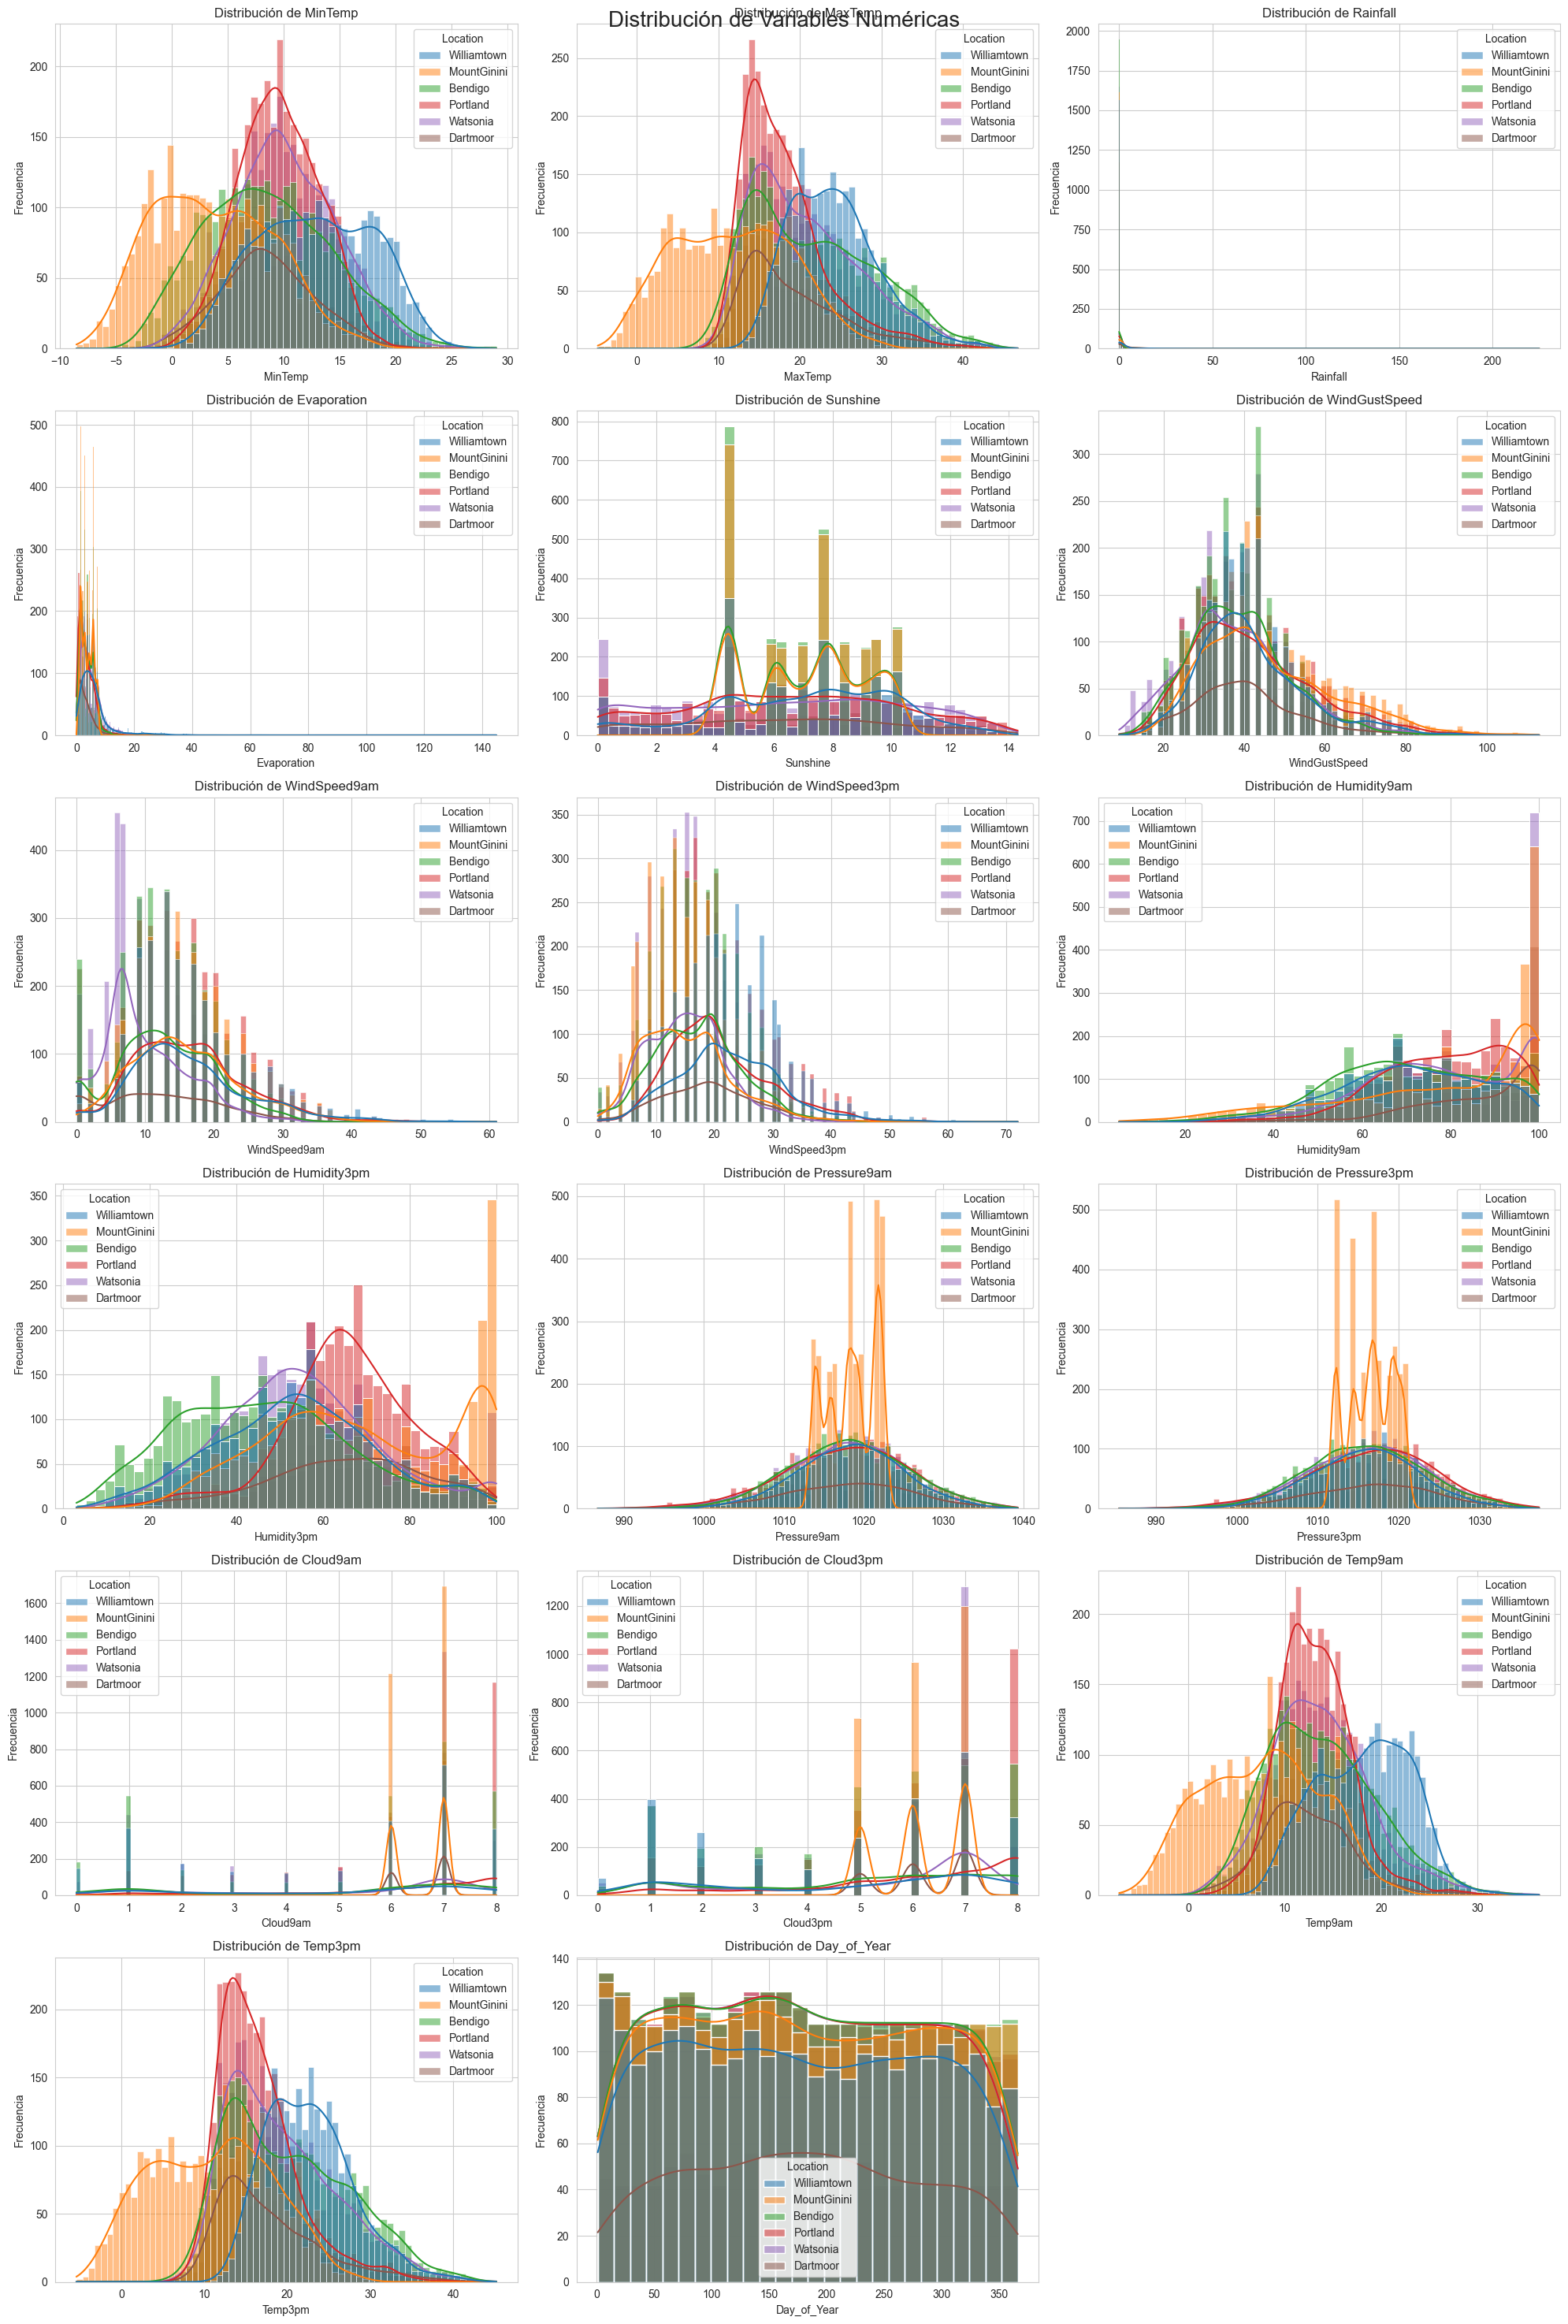

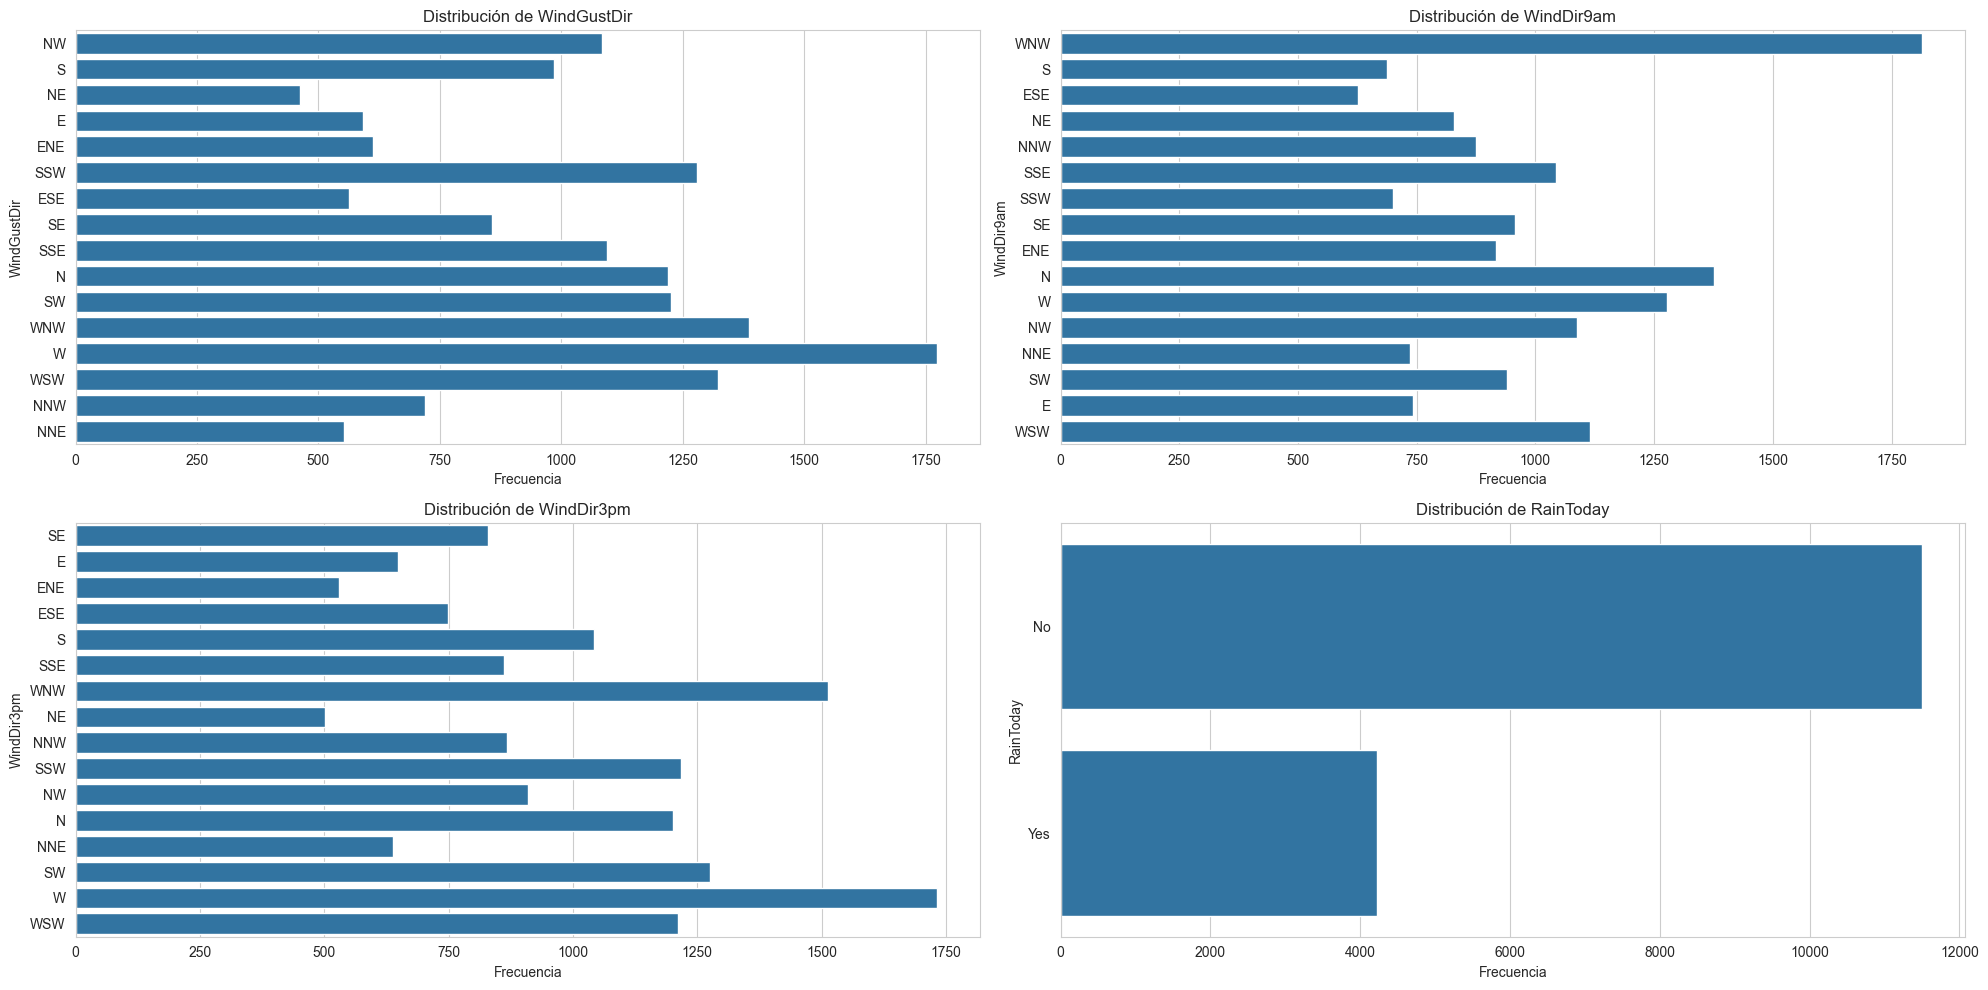

In [31]:
# Seleccionmos solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Configurmos el estilo de seaborn
sns.set_style("whitegrid")

# Calculmos el número de filas y columnas para el subplot
n_cols = 3 
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Distribución de Variables Numéricas', fontsize=20)

# Aplanmos el array de axes si es necesario
axes = axes.flatten() if n_rows > 1 else [axes]

# Creamos un histograma para cada variable numérica
for i, column in enumerate(numeric_columns):
    sns.histplot(X_train, x=column, kde=True, ax=axes[i], hue=X_train['Location'])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Frecuencia', fontsize=10)

# Quitamos subplots vacíos
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Para  las variables categóricas, excluyendo 'Date' y 'Location'
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in ['Date', 'Location']]

# Calculmosel número de filas y columnas para el subplot de variables categóricas
n_cols_cat = 2  # Puedes ajustar esto según prefieras
n_rows_cat = math.ceil(len(categorical_columns) / n_cols_cat)

fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5*n_rows_cat))

# Aplanmos el array de axes si es necesario
axes = axes.flatten() if n_rows_cat > 1 else [axes]

# Creamos un gráfico de barras para cada variable categórica
for i, column in enumerate(categorical_columns):
    sns.countplot(y=column, data=X_train, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel('Frecuencia', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)

# Quitamos subplots vacíos
for i in range(len(categorical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


Vemos que la variable 'Location' es importante en el modelo ya que influye en casi todas las demás variables; por lo tanto, no es una opción quitarla.

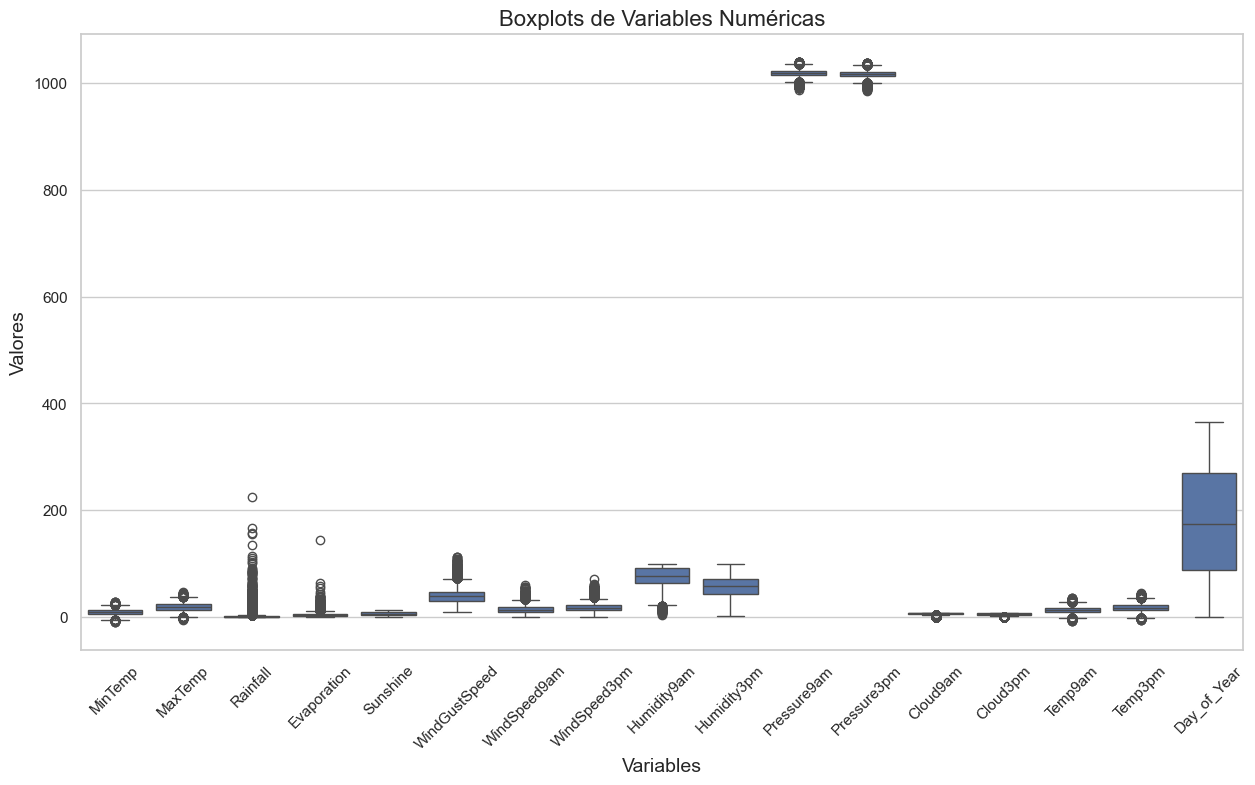

In [32]:
# Seleccionamos solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Transformamos el DataFrame a formato largo
X_train_melted = pd.melt(X_train, value_vars=numeric_columns)

# Configuramos el estilo de seaborn
sns.set(style="whitegrid")

# Cremos boxplots para todas las columnas numéricas en un solo gráfico
plt.figure(figsize=(15, 8))
sns.boxplot(x='variable', y='value', data=X_train_melted)
plt.title('Boxplots de Variables Numéricas', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(rotation=45)  # Rota etiquetas del eje x para mejor legibilidad
plt.show()

### Descripcion de variables ###

1. MinTemp: Al ser la temperatura mínima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, ligeramente sesgada a la izquierda. La moda parece estar alrededor de los 10-15°C. Aunque no tenemos un boxplot, es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o cálidos.

2. MaxTemp: Al ser la temperatura máxima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, posiblemente con un ligero sesgo a la derecha. La moda parece estar alrededor de los 20-25°C. Es probable que haya valores atípicos en el extremo superior, representando días excepcionalmente calurosos.

3. Rainfall: Al ser la cantidad de lluvia registrada en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución fuertemente sesgada a la derecha, con una moda muy pronunciada en o cerca de 0 mm. La distribución tiene una cola larga hacia la derecha, indicando días ocasionales de lluvia intensa. Es muy probable que haya numerosos valores atípicos en el extremo superior de la distribución.

4. Evaporation: Al ser la evaporación en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores concentrados en el rango inferior. La moda parece estar cerca de 2-4 mm. Es probable que haya valores atípicos en el extremo superior, representando días con evaporación excepcionalmente alta.

5. Sunshine: Al ser el número de horas de sol brillante en el día, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución que podría ser bimodal o uniforme, reflejando la variación estacional en las horas de luz diurna. La distribución probablemente abarca desde 0 hasta 12-14 horas, con picos que podrían corresponder a los patrones de invierno y verano.

6. WindGustSpeed: Al ser la velocidad de la ráfaga de viento más fuerte en las últimas 24 horas (km/h), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores en el rango bajo a medio. La moda parece estar alrededor de 30-40 km/h. Es probable que haya valores atípicos en el extremo superior, representando ráfagas de viento excepcionalmente fuertes.

7. WindSpeed9am y WindSpeed3pm: Al ser la velocidad del viento a las 9 am y 3 pm respectivamente (km/h), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones sesgadas a la derecha, similares a WindGustSpeed pero con valores generalmente más bajos. Las modas probablemente están en el rango de 10-20 km/h. Es probable que haya valores atípicos en los extremos superiores.

8. Humidity9am y Humidity3pm: Al ser el porcentaje de humedad a las 9 am y 3 pm respectivamente, podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones que podrían ser bimodales o uniformes, abarcando un rango amplio de valores. Las modas podrían estar alrededor del 60-70% y 40-50% respectivamente. Es menos probable que haya valores atípicos extremos debido a la naturaleza limitada de la escala de porcentaje.

9. Pressure9am y Pressure3pm: Al ser la presión atmosférica a las 9 am y 3 pm respectivamente (hpa), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, centradas alrededor de 1010-1020 hpa. La variación es relativamente pequeña, reflejando la estabilidad general de la presión atmosférica. Es posible que haya algunos valores atípicos en ambos extremos, representando condiciones atmosféricas inusuales.

10. Cloud9am y Cloud3pm: Al ser la fracción de cielo cubierto por nubes a las 9 am y 3 pm respectivamente (octavos), podemos observar que son variables cuantitativas discretas. Las distribuciones probablemente muestran picos en valores específicos (0, 4, 8 octavos), reflejando la naturaleza discreta de la medición. Podría haber una ligera tendencia hacia valores más altos o más bajos dependiendo del clima local.

11. Temp9am y Temp3pm: Al ser la temperatura a las 9 am y 3 pm respectivamente (°C), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, con Temp3pm generalmente más alta y posiblemente con mayor varianza que Temp9am. Las modas probablemente están alrededor de 15-20°C para Temp9am y 20-25°C para Temp3pm. Es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o calurosos.

12. RainToday y RainTomorrow: Al ser variables categóricas binarias (Sí/No) que indican si llovió hoy o si lloverá mañana, podemos observar que son variables cualitativas nominales. La distribución muestra dos barras, una para 'Sí' y otra para 'No'. Es probable que la barra de 'No' sea significativamente más alta, indicando que los días sin lluvia son más comunes que los días con lluvia.

Además podemos observar como variables como MinTemp y Maxtemp cambian su comportamiento según la estación del año, corroborando que la decisión sobre el llenado de datos faltantes fue correcta

Se tomo la desicion de trabajar con los datos atipicos ya que
* Se preservan mejor la integridad de los datos, ya que los datos atipicos, en este dataset, pueden representar variaciones naturales en los datos, y si se ignoran o se eliminan puede llevar a una perdida de informacion valiosa
* Mejora la robustez del modelo, ya que al trabajar con estos mismos, puede ayudar a mejorar la robustez del modelo.
* Evita la perdida de informacion, pues al eliminar estos datos atipicos, puede llegar a afectar la capacidad del modelo de aprender patrones significativos.

## Balance del modelo ##

RainTomorrow
No     0.72396
Yes    0.27604
Name: proportion, dtype: float64


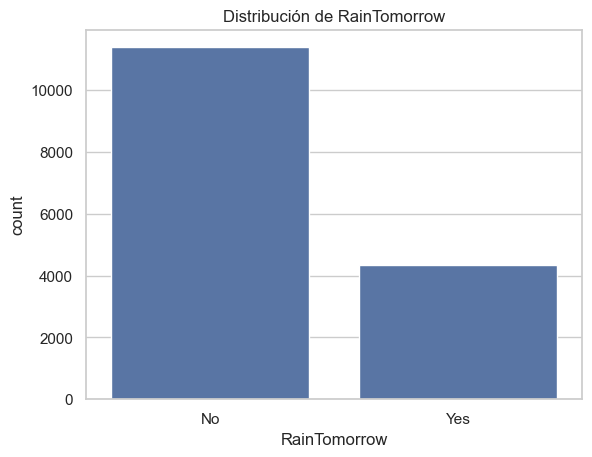

In [33]:
# Verificamos el balance de la variable objetivo (RainTomorrow)
print(pd.DataFrame(y_train)['RainTomorrow'].value_counts(normalize=True))

# Visualizamos el balance
sns.countplot(x='RainTomorrow', data=pd.DataFrame(y_train))
plt.title('Distribución de RainTomorrow')
plt.show()

Gracias al grafico, podemos ver que el dataset no esta balanceado, pues hay mas valores de que no va a llover, que de que si. Creemos que se hace esta pregunta para poder ver posibles problemas a futuro, como el impacto que tiene esto en el modelo.

Si no se aplican técnicas de balanceo, se puede generar un sesgo de predicción hacia la "No lluvia" ya que el modelo le asigna más penalidad el predecir mal esta variable dada su cantidad dentro del conjunto de entrenamiento, dejando con muy baja penalidad predecir mal el "Si lluvia" por su baja cantidad. Esto conduce a métricas engañosas ya que podría tener un accuracy muy alto sin significar que el modelo sea bueno.

## Codificacion de variables ##

Para codificar las variables, elegimos la representación en coordenadas polares sin-cos ya que de esta forma se disminuyen significativamente las columnas, manteniendo además la noción de 'antes' y 'después' en lo que respecta a días y de ubicación en lo que respecta a coordenadas cardenales.

In [34]:
def codificacion_localizacion(location: pd.Series) -> pd.DataFrame:
    location_to_coord = {
        'Williamtown': [-32.808996764, 151.838996644],
        'MountGinini': [-35.533, 148.783],
        'Bendigo': [-36.7581800, 144.2802400],
        'Portland': [-38.333332, 141.5999976],
        'Watsonia': [-37.69835, 145.08459],
        'Dartmoor': [-37.91439, 141.273],
        'Townsville': [-19.25762, 146.81788],
        'Launceston': [-41.43709, 147.13938],
        'AliceSprings': [-23.70021, 133.88061],
        'Katherine': [-14.46497, 132.26426]
    }
    
    # Mapeamos las ubicaciones a sus coordenadas
    coords = location.map(location_to_coord)
    
    # Creamos un DataFrame a partir de las coordenadas
    coords_df = pd.DataFrame(coords.tolist(), columns=['Latitude', 'Longitude'])
    
    # Retornamos la columna de latitud y longitud por separado
    latitude = coords_df['Latitude']
    longitude = coords_df['Longitude']    
    return latitude, longitude

In [35]:

def codificacion_coordenadas(column:pd.Series)-> pd.Series:
    '''
    Retorna dos columnas 'sin_cord' y 'cos_cord' que representan 
    en coordenadas polares la dirección cardinal.
    '''
    # Diccionario que asigna ángulos a cada dirección
    direction_to_angle = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Convertimos direcciones a ángulos
    angle = column.map(direction_to_angle)

    # Convertimos ángulos a radianes
    angle_rad = np.deg2rad(angle)

    # Calculamos senos y cosenos y devolver una tupla (sin, cos)

    sin_cord = np.sin(angle_rad)
    cos_cord = np.cos(angle_rad)

    return sin_cord, cos_cord


In [36]:
def codificacion(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Dado dos df X e y, devuelve dos df X_encoded e y_encoded con
    sus columnas dummies codificadas por coordenadas polares

    X: conjunto x
    y: conjunto y
    '''
    x_encoded = X.copy()
    y_encoded = y.copy()

    # Codificación de la fecha en coordenadas polares según el día del año
    x_encoded['angle_day_of_year'] = (x_encoded['Day_of_Year'] / 365.0) * 2 * np.pi

    # Calculamos senos y cosenos para el día del año
    x_encoded['sin_day'] = np.sin(x_encoded['angle_day_of_year'])
    x_encoded['cos_day'] = np.cos(x_encoded['angle_day_of_year'])

    # Codificación de las direcciones de viento en coordenadas polares
    x_encoded['sin_WindGustDir'], x_encoded['cos_WindGustDir'] = codificacion_coordenadas(x_encoded['WindGustDir'])
    x_encoded['sin_WindDir9am'], x_encoded['cos_WindDir9am'] = codificacion_coordenadas(x_encoded['WindDir9am'])
    x_encoded['sin_WindDir3pm'], x_encoded['cos_WindDir3pm'] = codificacion_coordenadas(x_encoded['WindDir3pm'])

    #Codificación RainToday
    x_encoded['RainToday'] = x_encoded['RainToday'].map({'Yes': 1,  'No':0})

    #Codificación Location
    latitude, longitude = codificacion_localizacion(x_encoded['Location'])
    x_encoded['Latitude'] = latitude.values
    x_encoded['Longitude'] = longitude.values
    # Convertimos 'yes' a 1 y 'no' a 0 en la variable objetivo
    y_encoded = y_encoded.map({'Yes': 1, 'No': 0})

    # Eliminamos columnas ya codificadas
    x_encoded = x_encoded.drop(columns=['Day_of_Year', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location'])

    return x_encoded, y_encoded



In [37]:
### Codificamos los 3 conjuntos.
X_train_encoded, y_train_encoded = codificacion(X_train,y_train)
X_val_encoded, y_val_encoded = codificacion(X_val,y_val)
X_test_encoded, y_test_encoded = codificacion(X_test,y_test)

In [38]:
#Chequeamos las columnas de todos los conjuntos
X_train_encoded.shape,X_val_encoded.shape, X_test_encoded.shape

((15726, 28), (6740, 28), (5617, 28))

In [39]:
#Chequeamos la forma del conjunto y
y_train_encoded.shape,y_val_encoded.shape, y_test_encoded.shape

((15726,), (6740,), (5617,))

In [40]:
### Nos aseguramos que se hayan codificado todas las columnas de X
(X_train_encoded.isna().sum() + X_val_encoded.isna().sum()+X_test_encoded.isna().sum()).sum()

0

In [41]:
### Nos aseguramos que se hayan codificado todas las columnas de y
(y_train_encoded.isna().sum()+y_val_encoded.isna().sum()+y_test_encoded.isna().sum()).sum()

0

## Matriz de correlacion de variables ## 

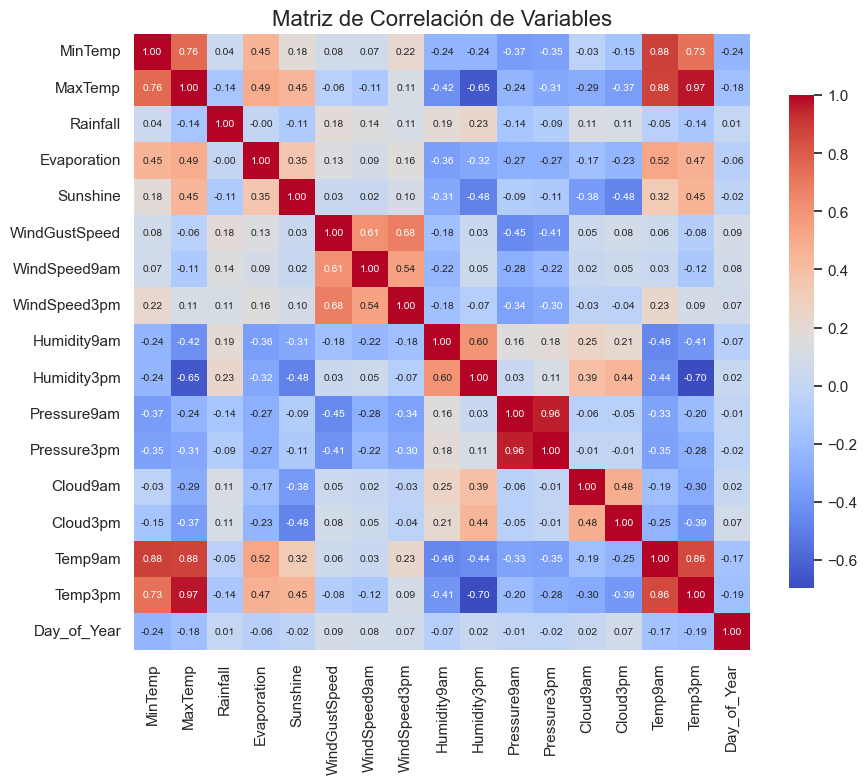

In [42]:
plt.figure(figsize=(10, 8))


sns.heatmap(X_train.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 7.5})

plt.title('Matriz de Correlación de Variables', fontsize=16)
plt.show()

Gracias a la matriz de correlacion, se pueden hacer algunas observaciones:

* MaxTemp y Temp3pm: También tienen una correlación muy alta (0.97), lo que indica que la temperatura máxima diaria tiende a estar cercana a la de las 3 pm.

* Pressure9am y Pressure3pm: La correlación es casi perfecta (0.95), lo que sugiere que la presión atmosférica no cambia mucho entre la mañana y la tarde.

* MinTemp y Temp9am: Tienen una correlación muy alta (0.88), lo que sugiere que la temperatura mínima registrada durante el día está muy ligada a la temperatura a las 9 de la mañana.

* MaxTemp y  Temp9am: Tienen una correlación muy alta (0.88), lo que sugiere que la temperatura máxima registrada durante el día también está muy ligada a la temperatura a las 9 de la mañana.

* Temp9am y Temp3pm: Hay una correlación casi perfecta (0.86) entre estas dos variables, lo que es esperable ya que las temperaturas en diferentes momentos del día suelen estar relacionadas.

* MinTemp y MaxTemp: Hay una fuerte correlación positiva (0.80), lo que indica que si la temperatura mínima sube, es probable que la temperatura máxima también lo haga.

* Cloud9am y Cloud3pm: La correlación (0.48) muestra que el porcentaje de nubosidad en la mañana tiende a predecir razonablemente bien la cantidad de nubosidad en la tarde.

In [43]:
#Creamos la matriz de correlacion
correlation_matrix = X_train.select_dtypes(include=['number']).corr()

# Aplanamos la matriz de correlación y reseteamos los índices
correlation_pairs = correlation_matrix.unstack().reset_index()

# Renombramos las columnas
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Eliminamos las correlaciones duplicadas (diagonal y columnas)
correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]

# Ordenamos por la mayor correlación positiva
correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Eliminamos duplicados y valores nulos
correlation_pairs.drop_duplicates(subset=['Correlation'], inplace=True)
correlation_pairs.dropna(inplace=True)

# Reseteamos el índice
correlation_pairs.reset_index(drop=True, inplace=True)

# Mostramos las 10 pares de variables con mayor correlación positiva y las 10 pares de variables con mayor correlación negativa
print(correlation_pairs.head(10), '\n', correlation_pairs.tail(10))

     Variable 1     Variable 2  Correlation
0       MaxTemp        Temp3pm     0.972721
1   Pressure3pm    Pressure9am     0.956598
2       Temp9am        MinTemp     0.883017
3       Temp9am        MaxTemp     0.880189
4       Temp9am        Temp3pm     0.859462
5       MaxTemp        MinTemp     0.756201
6       Temp3pm        MinTemp     0.727110
7  WindSpeed3pm  WindGustSpeed     0.677026
8  WindSpeed9am  WindGustSpeed     0.614888
9   Humidity3pm    Humidity9am     0.598987 
         Variable 1     Variable 2  Correlation
126        Temp3pm    Humidity9am    -0.405035
127  WindGustSpeed    Pressure3pm    -0.410993
128        MaxTemp    Humidity9am    -0.422752
129    Humidity3pm        Temp9am    -0.438490
130    Pressure9am  WindGustSpeed    -0.447772
131        Temp9am    Humidity9am    -0.462118
132       Cloud3pm       Sunshine    -0.475511
133       Sunshine    Humidity3pm    -0.480576
134    Humidity3pm        MaxTemp    -0.649800
135    Humidity3pm        Temp3pm    -0.6973

## Estandarizacion y escalado de datos ##

Gracias a los boxplots hechos anteriormente, podemos ver una cantidad de valores atipicos grande, entonces lo que mas nos conviene es usar un escalado robusto

# Punto 2

Implementar la solución del problema de clasificación con regresión logística.

## Weighted vs Balanced

In [44]:
logist_class_w = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_w.fit(X_train_encoded,y_train_encoded)
logist_class_b = make_pipeline(RobustScaler(), LogisticRegression(random_state=42, class_weight='balanced'))
logist_class_b.fit(X_train_encoded,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

### Matriz de Confusión Modelos W y B

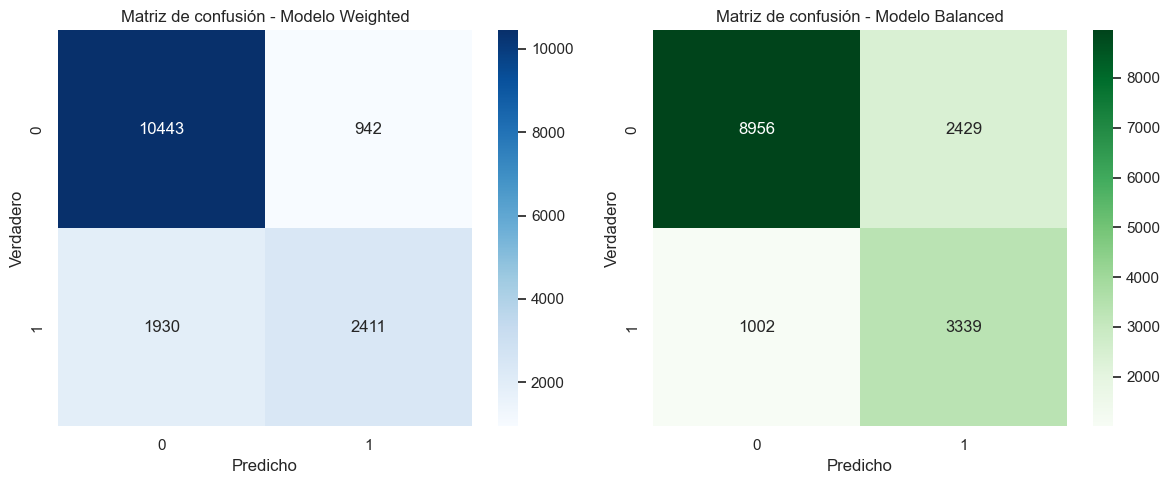

In [45]:
# Predecir las etiquetas en el conjunto de prueba o validación (usa el conjunto que prefieras)
y_train_pred_w = logist_class_w.predict(X_train_encoded)
y_train_pred_b = logist_class_b.predict(X_train_encoded)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train_encoded, y_train_pred_w)
cmb = confusion_matrix(y_train_encoded, y_train_pred_b)

# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap para la primera matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Weighted")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")

# Heatmap para la segunda matriz de confusión
sns.heatmap(cmb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Balanced")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [46]:
y_train_encoded.value_counts()

RainTomorrow
0    11385
1     4341
Name: count, dtype: int64

Definiendo clase Positiva a "Lluvia"

Modelo Weighted:
- Falsos Positivos: Hubo 942 días en los que se predijo que no iba a llover (0) y llovió (1).
- Falsos Negativos: Hubo 1.930 días en los que se predijo que iba a llover (1) y no llovió (0).

Modelo Balanced:
- Falsos Positivos: Hubo 2.429 días en los que se predijo que no iba a llover (0) y llovió (1)
- Falsos Negativos: Hubo 1.002 días en los que se predijo que iba a llover (1) y no llovió (0)

En el primer modelo (Weighted), tiene sentido que el dataset esté desbalanceado, con una mayor proporción de días en los que "No llueve" (0). Como se priorizó predecir correctamente los días en los que no llueve, se obtuvo un número alto de predicciones correctas para esta clase (11,282), con solo 750 días mal predichos (falsos positivos). Sin embargo, la clase "Llueve" (1) tuvo un desempeño inferior, con solo 1,930 días correctamente predichos y 1,770 días mal predichos (falsos negativos), lo que significa que la mitad de los días en los que llovió no fueron correctamente identificados.

En el segundo modelo (Balanced), al aplicar una penalización mayor a la clase con menos datos ("Llueve"), se logra disminuir significativamente la tasa de falsos negativos, reduciéndolos a 841. Sin embargo, el número de falsos positivos aumenta considerablemente, casi triplicándose a 2,455. Esto refleja que se ha logrado balancear las detecciones de ambas clases, pero a costa de aumentar los errores en los días que no llueve.

#### Vemos la diferencia en las metricas

In [47]:
# Calculmos las métricas
metrics_train_w = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_w),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_w, pos_label=1),  # Precision para clase 1 (Llueve)
        recall_score(y_train_encoded, y_train_pred_w, pos_label=1),  # Recall para clase 1 (Llueve)
        f1_score(y_train_encoded, y_train_pred_w, pos_label=1),  # F1 Score para clase 1 (Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_w),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_w),  # Kappa (global)
        roc_auc_score(y_train_encoded, logist_class_w.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 1 (Llueve)
    ],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_w),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_w, pos_label=0),  # Precision para clase 0 (No Llueve)
        recall_score(y_train_encoded, y_train_pred_w, pos_label=0),  # Recall para clase 0 (No Llueve)
        f1_score(y_train_encoded, y_train_pred_w, pos_label=0),  # F1 Score para clase 0 (No Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_w),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_w),  # Kappa (global)
        1 - roc_auc_score(y_train_encoded, logist_class_w.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 0 (No Llueve)
    ]
}


In [48]:
# Convertimos a DataFrame
df_metrics_train_w = pd.DataFrame(metrics_train_w)

# Mostramos el DataFrame
df_metrics_train_w

,Metricas,Llueve,No Llueve
0,Accuracy,0.817373,0.817373
1,Precision,0.719058,0.844015
2,Recall,0.555402,0.917260
3,F1 Score,0.626722,0.879114
4,MCC,0.515890,0.515890
5,Cohen's Kappa,0.508461,0.508461
6,AUC Roc,0.860877,0.139123


**Accuracy**

El accuracy general del modelo es relativamente alto (81.73%). Sin embargo, dado que las clases están desbalanceadas, esta métrica por sí sola no es suficiente para evaluar el rendimiento del modelo en detalle ya que se trata de un modelo desbalanceado.

**Precision**

- Para la clase "Llueve", la precisión es del 71.9%, lo que significa que, de todas las predicciones positivas (cuando se predijo que iba a llover), el 71.9% fueron realmente positivas. Esto indica que el modelo genera algunos falsos positivos.
- Para la clase "No Llueve", la precisión es alta, con un 84.4%, lo que sugiere que el modelo es más confiable al predecir los días en los que no llueve.

**Recall**

- El recall para "Llueve" es del 55.54%, lo que significa que el modelo solo identifica correctamente el 55.54% de los días en los que realmente llovió. Esto es preocupante porque indica que el modelo pierde una cantidad significativa de instancias de lluvia, lo que puede ser crítico en situaciones donde es importante predecir los días de lluvia.
- En contraste, el recall para "No Llueve" es muy alto, 91.72%, lo que sugiere que el modelo es efectivo para identificar los días en los que no llueve, aunque esto puede estar ocurriendo a expensas de la clase "Llueve".

**F1 Score**

- El F1 Score para la clase "Llueve" es de 62.67%, lo que refleja un rendimiento moderado del modelo en esta clase, equilibrando la precisión y el recall.
- Para la clase "No Llueve", el F1 Score es significativamente más alto, 87.91%, lo que muestra un mejor rendimiento del modelo para identificar correctamente los días sin lluvia.

**MCC (Matthews Correlation Coefficient)**

El MCC es 0.5158, lo que indica un rendimiento moderado del modelo. Esta métrica tiene en cuenta tanto verdaderos como falsos positivos y negativos, por lo que es útil en conjuntos de datos desbalanceados como este.
Cohen's Kappa:

**Kappa**

La puntuación de Cohen's Kappa es 0.5084, lo que indica un acuerdo moderado entre las predicciones del modelo y las etiquetas reales, sugiriendo que el modelo es mejor que uno aleatorio, pero aún con margen de mejora.
AUC-ROC:

**AUC-ROC**

El AUC-ROC es de 0.860877, lo que indica que el modelo tiene una capacidad razonablemente alta para diferenciar entre días de lluvia y días sin lluvia.


**Conclusión sobre el desbalance de clases**

El modelo tiene un buen rendimiento para la clase "No Llueve", pero sufre considerablemente con la clase "Llueve", como se refleja en el menor recall y F1 score. Esto es común en modelos que no están ajustados para manejar datos desbalanceados, y puede llevar a decisiones incorrectas en aplicaciones donde es crucial identificar los días de lluvia.

In [49]:
metrics_train_b = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
        'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_b),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_b, pos_label=1),  # Precision para clase 1 (Llueve)
        recall_score(y_train_encoded, y_train_pred_b, pos_label=1),  # Recall para clase 1 (Llueve)
        f1_score(y_train_encoded, y_train_pred_b, pos_label=1),  # F1 Score para clase 1 (Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_b),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_b),  # Kappa (global)
        roc_auc_score(y_train_encoded, logist_class_b.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 1 (Llueve)
    ],

    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_b),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_b, pos_label=0),  # Precision para clase 0 (No Llueve)
        recall_score(y_train_encoded, y_train_pred_b, pos_label=0),  # Recall para clase 0 (No Llueve)
        f1_score(y_train_encoded, y_train_pred_b, pos_label=0),  # F1 Score para clase 0 (No Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_b),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_b),  # Kappa (global)
        1- roc_auc_score(y_train_encoded, logist_class_b.predict_proba(X_train_encoded)[:, 1]) # AUC para clase 0 (No Llueve)
    ]
}


In [50]:
# Convertir a DataFrame
df_metrics_train_b = pd.DataFrame(metrics_train_b)

# Mostrar el DataFrame
df_metrics_train_b

,Metricas,Llueve,No Llueve
0,Accuracy,0.781826,0.781826
1,Precision,0.578883,0.899377
2,Recall,0.769178,0.786649
3,F1 Score,0.660599,0.839245
4,MCC,0.515587,0.515587
5,Cohen's Kappa,0.504521,0.504521
6,AUC Roc,0.861105,0.138895


**Accuracy**

El accuracy es 0.7818, lo cual, aunque es menor que el del modelo no balanceado, al tener penalidades balanceadas es un valor más "realista". Esto significa que el modelo está equilibrando mejor ambas clases.
Precision:

**Precisión**
- Para la clase "Llueve", la precisión es de 57.88%, lo que significa que un poco más de la mitad de las predicciones positivas (cuando el modelo predice lluvia) son correctas. Esta es una reducción significativa en comparación con el modelo no balanceado, lo que indica que el modelo está dispuesto a aceptar más falsos positivos para mejorar la capacidad de capturar los días lluviosos.
- Para la clase "No Llueve", la precisión sigue siendo alta, en 89.93%, lo que indica que el modelo sigue siendo muy confiable cuando predice que no va a llover.

**Recall**

- El recall para la clase "Llueve" es 76.91%, lo que significa que el modelo identifica correctamente la mayoría de los días en los que realmente llueve, mejorando considerablemente respecto al modelo no balanceado.
- Para la clase "No Llueve", el recall es 78.66%, menor que el del modelo no balanceado, pero sigue siendo bueno y muestra que el modelo sigue capturando adecuadamente la mayoría de los días sin lluvia.

**F1 Score**

- El F1 Score para "Llueve" es de 66.05%, lo que refleja un rendimiento moderado, equilibrando precisión y recall. Este valor es más alto que en el modelo no balanceado, lo que indica una mejora general en la capacidad del modelo para manejar la clase minoritaria ("Llueve").
- Para "No Llueve", el F1 Score es 83.92%, lo que sigue reflejando un excelente rendimiento para la clase mayoritaria.

**MCC (Matthews Correlation Coefficient)**

El MCC es 0.5155, lo que sugiere un rendimiento moderado. Aunque no es perfecto, esta métrica sigue siendo mejor que un rendimiento al azar y refleja un buen balance en el rendimiento del modelo para ambas clases.

**Cohen's Kappa**

La puntuación de Cohen's Kappa es 0.5045, lo que indica un acuerdo moderado entre las predicciones del modelo y las etiquetas reales. Este valor es similar al del modelo no balanceado, sugiriendo que hay margen de mejora en el acuerdo global.

**AUC-ROC**

El modelo tiene una AUC-ROC de 0.8611, similar al anterior.

##### Mejora en el Recall

El modelo balanceado muestra una mejora significativa en el recall para la clase "Llueve" en comparación con el modelo no balanceado. Esto significa que el modelo es más efectivo en identificar instancias de lluvia, lo cual es crítico en situaciones donde es importante no perder casos positivos (como predicciones de eventos climáticos adversos).

##### Compromiso entre Clases

La precisión de la clase "Llueve" ha disminuido en comparación con el modelo no balanceado, lo que indica que el modelo está dispuesto a aceptar más falsos positivos con el fin de mejorar su capacidad para identificar los días lluviosos. Este es un trade-off común en modelos balanceados y puede ser aceptable dependiendo del contexto del problema.

### Curva ROC modelos W y B

Trazar curvas ROC para cada modelo. Comenten cuáles serían los umbrales adecuados a utilizar; ¿cómo podrían calcular el mejor umbral? ¿Es 0.5 el mejor?

In [51]:
#Probabilidades de predicción modelo w
y_train_probs_w = logist_class_w.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_w, tpr_w, thresholds_w = roc_curve(y_train_encoded, y_train_probs_w)

roc_auc_w = auc(fpr_w, tpr_w)

#Probabilidades de predicción modelo b
y_train_probs_b = logist_class_b.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_b, tpr_b, thresholds_b = roc_curve(y_train_encoded, y_train_probs_b)

roc_auc_b = auc(fpr_b, tpr_b)

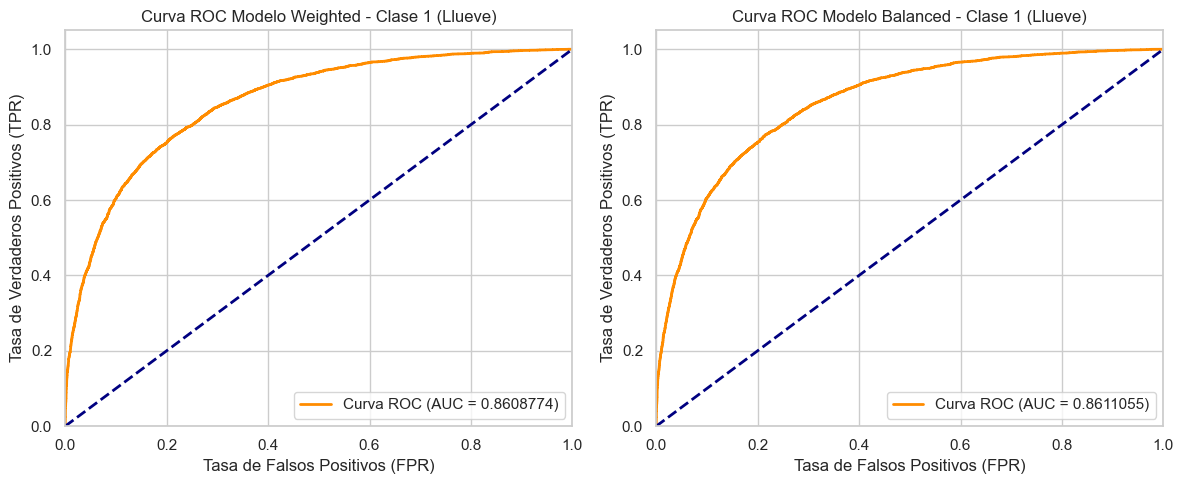

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC AUC para modelo Weighted (Clase 1: Llueve)
axes[0].plot(fpr_w, tpr_w, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc_w)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC Modelo Weighted - Clase 1 (Llueve)')
axes[0].legend(loc="lower right")

# Curva ROC AUC para modelo Balanced (Clase 1: Llueve)
axes[1].plot(fpr_b, tpr_b, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc_b)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC Modelo Balanced - Clase 1 (Llueve)')
axes[1].legend(loc="lower right")

# Ajustamos el espaciado entre gráficos
plt.tight_layout()
plt.show()




##### Modelo Weighted.
- Clase 1 (Llueve):
    El AUC es 0.8608, lo que sugiere que el modelo ponderado tiene un buen rendimiento al predecir la clase "Llueve". La curva ROC está alejada de la diagonal, lo que indica que el modelo tiene una buena capacidad de distinguir entre "Llueve" y "No Llueve", con una baja tasa de falsos positivos y una alta tasa de verdaderos positivos.

##### Modelo Balanced
- Clase 0 (No Llueve):
    El AUC es 0.8611, casi idéntico al del modelo ponderado. Esto indica que el balanceo de las clases no ha mejorado el rendimiento del modelo en la predicción signidicativamente.


##### Conclusión general
El modelo tiene un rendimiento similar para predecir la clase "Llueve", tanto en la versión ponderada como balanceada, con un AUC alrededor de 0.86. 





#### Auc
El AUC (Área Bajo la Curva) es de 0.86 aproximada para ambas, lo cual es una buena señal ya que esta cerca de 1 (es decir, cerca de tener un buen poder de discriminación entre clases).
El mejor umbral se puede calcular como aquel punto en la curva ROC que tenga la menor distancia euclidiana al punto (1,0). 
0.5 generalmente suele ser un buen umbral para modelos balanceados, como este no es el caso, no sería el mejor umbral.

### Fitting Modelos W y B

El fitting no es el mejor, ya que hay una gran diferencia entre los verdaderos positivos de No Lluvia y los verdaderos negativos de No Lluvia. Esto puede deberse al mal balanceo de clases, a pesar de proponer el modelo balanced.

## Modelo Balanceado con Oversampling

In [53]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_encoded, y_train_encoded)

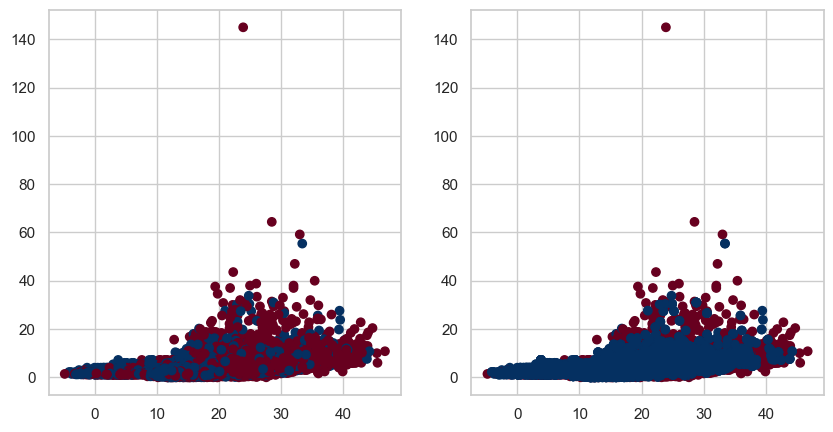

In [54]:
##Vemos la diferencia entre el original y el oversampled para dos columnas
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train_encoded['MaxTemp'], X_train_encoded['Evaporation'], c=y_train_encoded, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled['MaxTemp'], X_resampled['Evaporation'], c=y_resampled, cmap=plt.cm.RdBu)
plt.show()

### Modelo Logistic oversampled

In [55]:
logist_class_oversampled = make_pipeline(RobustScaler(), LogisticRegression(random_state = 9))

In [56]:
logist_class_oversampled.fit(X_resampled,y_resampled)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=9))])

In [57]:
y_train_pred_ov = logist_class_oversampled.predict(X_resampled)

### Matriz de confusión modelo oversampled

In [58]:
cm_ov = confusion_matrix(y_resampled, y_train_pred_ov)

### Heatmap para la segunda matriz de confusión

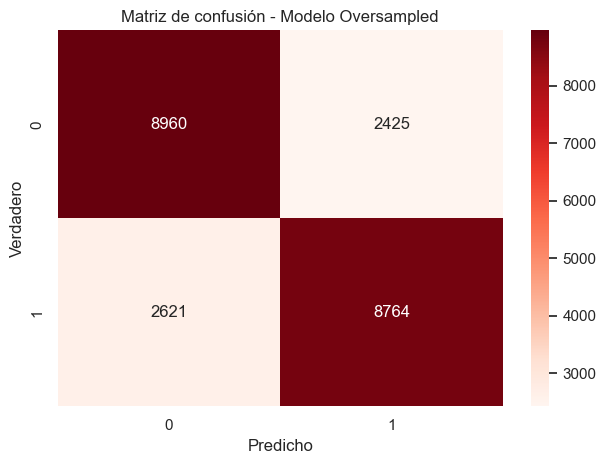

In [59]:
sns.heatmap(cm_ov, annot=True, fmt="d", cmap="Reds")
plt.title("Matriz de confusión - Modelo Oversampled")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Se ve que el modelo tiene una cantidad de falsos negativos similar al modelo balanced, sin embargo, hay que tener en cuenta los valores de las métricas ya que al hacer oversampling se estan agregando datos.
- Falsos Positivos: Hubo 2.425 días en los que se predijo que no iba a llover (0) y llovió (1). 
- Falsos Negativos: Hubo 2.621 días en los que se predijo que iba a llover (1) y no llovió (0). 


### Métricas modelo oversampled

In [60]:
# Calcular las métricas
metrics_train_ov = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
        'Llueve': [
        accuracy_score(y_resampled, y_train_pred_ov),  # Accuracy para clase 2
        precision_score(y_resampled, y_train_pred_ov, pos_label=1),  # Precision para clase 2
        recall_score(y_resampled, y_train_pred_ov, pos_label=1),  # Recall para clase 2
        f1_score(y_resampled, y_train_pred_ov, pos_label=1),  # F1 Score para clase 2
        matthews_corrcoef(y_resampled, y_train_pred_ov),  # MCC para clase 2
        cohen_kappa_score(y_resampled, y_train_pred_ov),  # Kappa para clase 2
        roc_auc_score(y_resampled, logist_class_b.predict_proba(X_resampled)[:, 1])  # AUC para clase 2
    ],

    'No Llueve': [
        accuracy_score(y_resampled, y_train_pred_ov),  # Accuracy para clase 1
        precision_score(y_resampled, y_train_pred_ov, pos_label=0),  # Precision para clase 1
        recall_score(y_resampled, y_train_pred_ov, pos_label=0),  # Recall para clase 1
        f1_score(y_resampled, y_train_pred_ov, pos_label=0),  # F1 Score para clase 1
        matthews_corrcoef(y_resampled, y_train_pred_ov),  # MCC para clase 1
        cohen_kappa_score(y_resampled, y_train_pred_ov),  # Kappa para clase 1
        roc_auc_score(y_resampled, logist_class_b.predict_proba(X_resampled)[:, 0])  # AUC para clase 1
    ]
}

In [61]:
df_metrics_train_ov = pd.DataFrame(metrics_train_ov)

## Comparación modelo Weighted, Balanced y Oversampled

In [62]:
df_metrics_train_ov

,Metricas,Llueve,No Llueve
0,Accuracy,0.778393,0.778393
1,Precision,0.783269,0.773681
2,Recall,0.769785,0.787000
3,F1 Score,0.776469,0.780284
4,MCC,0.556868,0.556868
5,Cohen's Kappa,0.556785,0.556785
6,AUC Roc,0.859915,0.140085


In [63]:
df_metrics_train_w

,Metricas,Llueve,No Llueve
0,Accuracy,0.817373,0.817373
1,Precision,0.719058,0.844015
2,Recall,0.555402,0.917260
3,F1 Score,0.626722,0.879114
4,MCC,0.515890,0.515890
5,Cohen's Kappa,0.508461,0.508461
6,AUC Roc,0.860877,0.139123


In [64]:
df_metrics_train_b

,Metricas,Llueve,No Llueve
0,Accuracy,0.781826,0.781826
1,Precision,0.578883,0.899377
2,Recall,0.769178,0.786649
3,F1 Score,0.660599,0.839245
4,MCC,0.515587,0.515587
5,Cohen's Kappa,0.504521,0.504521
6,AUC Roc,0.861105,0.138895


Se puede ver que entre los 3 modelos, aquel que tiene una mayor consistencia para ambas clases es el oversampled; se ve que tiene un MCC de 0.5568 lo que indica que teien un rendimiento global más consistente entre clases, como así tambien obtiene el mejor resultado en Cohen's Kappa (0.5567), indicando mejor acuerdo entre el modelo y la etiqueta verdadera comparado con los otros dos modelos.

Conclusión General:
- Modelo Oversampled: Tiene un buen balance entre precisión y recall, con un MCC y Kappa ligeramente superiores. Si se busca un modelo que tenga un desempeño estable entre ambas clases, este modelo parece una buena opción.
- Modelo Weighted: Es excelente para predecir "No Llueve" (alta precisión, recall y F1 score para esa clase), pero sufre bastante en la predicción de "Llueve", con un recall bajo (55.54%).
- Modelo Balanced: Mantiene un equilibrio intermedio, destacando en precisión para "No Llueve" (89.93%) y con un recall mejorado para "Llueve" (76.91%), pero su precisión para "Llueve" es más baja (57.88%).


Cada modelo tiene sus fortalezas según la clase en la que se quiera enfocar. El modelo oversampled parece el más balanceado, pero el weighted puede ser útil si la clase "No Llueve" es más importante para el objetivo.

### Curva ROC - AUC para modelo oversampled

In [65]:
#Probabilidades de predicción modelo oversampled
y_train_probs_ov = logist_class_oversampled.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC para clase No Llueve
fpr_ov, tpr_ov, thresholds_ov = roc_curve(y_train_encoded, y_train_probs_ov)

roc_auc_ov = auc(fpr_ov, tpr_ov)

# Curva ROC AUC para la clase Llueve
fpr_ov_no_llueve, tpr_ov_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_ov)
roc_auc_no_ov_llueve = auc(fpr_ov_no_llueve, tpr_ov_llueve)

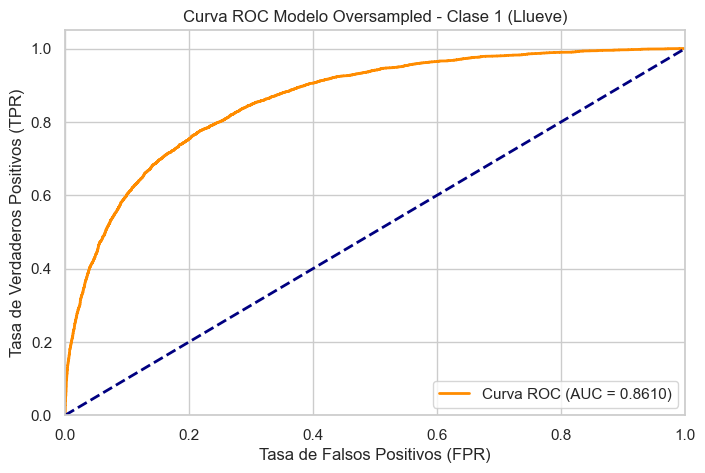

In [66]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
# Curva ROC AUC para modelo Oversampled (Clase 1: Llueve)
axes.plot(fpr_ov, tpr_ov, color='darkorange', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_ov)
axes.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('Tasa de Falsos Positivos (FPR)')
axes.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes.set_title('Curva ROC Modelo Oversampled - Clase 1 (Llueve)')
axes.legend(loc="lower right")


Los tres modelos tienen AUCs casi idénticas para ambas clases. Lo que sugiere que los tres modelos tienen similar capacidad para discriminar entre las clases.

### Métrica elegida para evaluar.

Se elige la métrica 'F1-Score' en especial para la clase 1 (Llueve) ya que nos interesa que el modelo prediga de manera óptima esta clase.

### Fitting modelo oversampled

In [67]:
df_metrics_train_ov

,Metricas,Llueve,No Llueve
0,Accuracy,0.778393,0.778393
1,Precision,0.783269,0.773681
2,Recall,0.769785,0.787000
3,F1 Score,0.776469,0.780284
4,MCC,0.556868,0.556868
5,Cohen's Kappa,0.556785,0.556785
6,AUC Roc,0.859915,0.140085


Siguiendo con el interés de que el modelo prediga bien los días que llueve, se obtiene un buen fitting en relación a la métrica de interés F1-Score y de las que esta nace (Recall y Precisión).
Esto quiere decir que dentro de la clase Lluvia, el 0.7697 fueron bien clasificadas (Recall); de las que fueron clasificadas como lluvia, el 0.7832 realmente lo eran (Precisión) y la media armónica entre ambos (F1-Score) también da una medida buena (0.7764). 

# Punto 3

### Modelo Base 1: regresión lineal

In [68]:
X_train_regresion = X_train_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_val_regresion = X_val_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_test_regresion = X_test_encoded[['MaxTemp', 'Temp3pm', 'Temp9am']]


In [69]:
model_linear_R = make_pipeline(RobustScaler(),LinearRegression())
model_linear_R.fit(X_train_regresion, y_train_encoded)

# Paso 2: Validar el modelo con el conjunto de validación

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [70]:
## Predicciones
y_train_pred_lr = model_linear_R.predict(X_train_regresion)
y_val_pred_lr = model_linear_R.predict(X_val_regresion)
y_test_pred_lr = model_linear_R.predict(X_test_regresion)

In [71]:

mse_train_lr = mean_squared_error(y_train_encoded, y_train_pred_lr)
r2_train_lr = r2_score(y_train_encoded, y_train_pred_lr)


mse_val = mean_squared_error(y_val_encoded, y_val_pred_lr)
r2_val = r2_score(y_val_encoded, y_val_pred_lr)

mse_test = mean_squared_error(y_test_encoded, y_test_pred_lr)
r2_test = r2_score(y_test_encoded, y_test_pred_lr)


# Convertir las predicciones continuas a etiquetas binarias con un umbral de 0.5
y_train_pred_discreto= [1 if pred >= 0.5 else 0 for pred in y_train_pred_lr]
y_val_pred_discreto= [1 if pred >= 0.5 else 0 for pred in y_val_pred_lr]
y_test_pred_discreto = [1 if pred >= 0.5 else 0 for pred in y_test_pred_lr]

### Modelo Base 1: Regresión Logística.

In [72]:
logist_class_regresion = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_regresion.fit(X_train_regresion,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [73]:
# Predecimos las etiquetas en el conjunto de validacion
y_train_pred_regresion = logist_class_regresion.predict(X_train_regresion)


### Modelo base 2: moda

In [74]:
#Hacemos la moda a nivel global ya que por mes, la moda en todos es 'NO'
moda = y_train_encoded.mode()[0]
y_pred_moda = [moda] * len(y_train_encoded)

### Modelo base 3: random

In [75]:
np.random.seed(42)
y_pred_random = np.random.choice(y_train_encoded.unique(), size=len(y_train_encoded))

In [76]:
regresion_metricas_test = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
        'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_regresion),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_regresion, pos_label=1),  # Precision para clase 1 (Llueve)
        recall_score(y_train_encoded, y_train_pred_regresion, pos_label=1),  # Recall para clase 1 (Llueve)
        f1_score(y_train_encoded, y_train_pred_regresion, pos_label=1),  # F1 Score para clase 1 (Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_regresion),  # MCC para clase 1
        cohen_kappa_score(y_train_encoded, y_train_pred_regresion),  # Kappa para clase 1
        roc_auc_score(y_train_encoded, logist_class_regresion.predict_proba(X_train_regresion)[:, 1])  # AUC para clase 1 (Llueve)
    ],

    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_regresion),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_regresion, pos_label=0),  # Precision para clase 0 (No Llueve)
        recall_score(y_train_encoded, y_train_pred_regresion, pos_label=0),  # Recall para clase 0 (No Llueve)
        f1_score(y_train_encoded, y_train_pred_regresion, pos_label=0),  # F1 Score para clase 0 (No Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_regresion),  # MCC para clase 0
        cohen_kappa_score(y_train_encoded, y_train_pred_regresion),  # Kappa para clase 0
        1- roc_auc_score(y_train_encoded, logist_class_regresion.predict_proba(X_train_regresion)[:, 1]) # AUC para clase 0 (No Llueve)
    ]
}

In [77]:
random_metricas = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_pred_random),  # Accuracy para clase 0
        precision_score(y_train_encoded, y_pred_random, pos_label=0),  # Precision para clase 0
        recall_score(y_train_encoded, y_pred_random, pos_label=0),  # Recall para clase 0
        f1_score(y_train_encoded, y_pred_random, pos_label=0),  # F1 Score para clase 0
        matthews_corrcoef(y_train_encoded, y_pred_random),  # MCC para clase 0
        cohen_kappa_score(y_train_encoded, y_pred_random),  # Kappa para clase 0
        roc_auc_score(y_train_encoded, y_pred_random)# AUC para clase 0
    ],
    'Llueve': [
        accuracy_score(y_train_encoded, y_pred_random),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_pred_random, pos_label=1),  # Precision para clase 1
        recall_score(y_train_encoded, y_pred_random, pos_label=1),  # Recall para clase 1
        f1_score(y_train_encoded, y_pred_random, pos_label=1),  # F1 Score para clase 1
        matthews_corrcoef(y_train_encoded, y_pred_random),  # MCC para clase 1
        cohen_kappa_score(y_train_encoded, y_pred_random),  # Kappa para clase 1
        roc_auc_score(y_train_encoded, y_pred_random)# AUC para clase 1
    ]
}

In [78]:
moda_metricas = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_pred_moda),  # Accuracy para clase 0
        precision_score(y_train_encoded, y_pred_moda, pos_label=0),  # Precision para clase 0
        recall_score(y_train_encoded, y_pred_moda, pos_label=0),  # Recall para clase 0
        f1_score(y_train_encoded, y_pred_moda, pos_label=0),  # F1 Score para clase 0
        matthews_corrcoef(y_train_encoded, y_pred_moda),  # MCC para clase 0
        cohen_kappa_score(y_train_encoded, y_pred_moda),  # Kappa para clase 0
        roc_auc_score(y_train_encoded, y_pred_moda)# AUC para clase 0
    ],
    'Llueve': [
        accuracy_score(y_train_encoded, y_pred_moda),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_pred_moda, pos_label=1),  # Precision para clase 1
        recall_score(y_train_encoded, y_pred_moda, pos_label=1),  # Recall para clase 1
        f1_score(y_train_encoded, y_pred_moda, pos_label=1),  # F1 Score para clase 1
        matthews_corrcoef(y_train_encoded, y_pred_moda),  # MCC para clase 1
        cohen_kappa_score(y_train_encoded, y_pred_moda),  # Kappa para clase 1
        roc_auc_score(y_train_encoded, y_pred_moda)# AUC para clase 1
    ]
}


In [79]:
regresion_metricas_df = pd.DataFrame(regresion_metricas_test)
random_metricas_df = pd.DataFrame(random_metricas)
moda_metricas_df = pd.DataFrame(moda_metricas)

## Comparación modelo Base Regresion, Random y Moda

In [80]:
regresion_metricas_df

,Metricas,Llueve,No Llueve
0,Accuracy,0.742338,0.742338
1,Precision,0.655879,0.747753
2,Recall,0.140060,0.971981
3,F1 Score,0.230828,0.845249
4,MCC,0.212657,0.212657
5,Cohen's Kappa,0.148063,0.148063
6,AUC Roc,0.720465,0.279535


In [81]:
random_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.496248,0.496248
1,Precision,0.719039,0.271065
2,Recall,0.499253,0.488367
3,F1 Score,0.589321,0.348627
4,MCC,-0.011069,-0.011069
5,Cohen's Kappa,-0.009920,-0.009920
6,AUC Roc,0.493810,0.493810


In [82]:
moda_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.72396,0.72396
1,Precision,0.72396,0.00000
2,Recall,1.00000,0.00000
3,F1 Score,0.83988,0.00000
4,MCC,0.00000,0.00000
5,Cohen's Kappa,0.00000,0.00000
6,AUC Roc,0.50000,0.50000


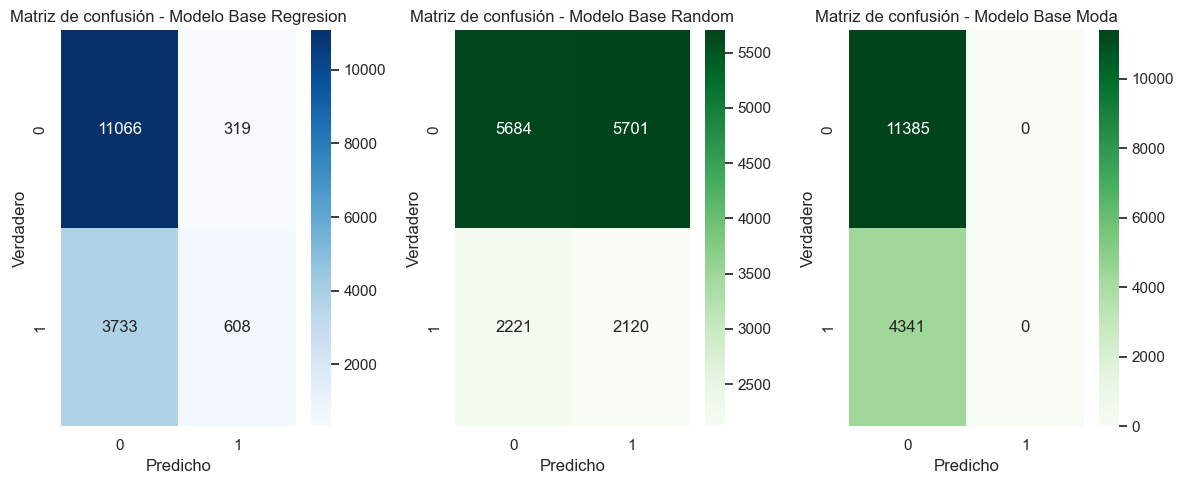

In [83]:
cm_regresion = confusion_matrix(y_train_encoded, y_train_pred_regresion)
randomm = confusion_matrix(y_train_encoded, y_pred_random)
moda = confusion_matrix(y_train_encoded, y_pred_moda)


# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(12, 5))


# Heatmap para la primera matriz de confusión
sns.heatmap(cm_regresion, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Base Regresion")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")


# Heatmap para la segunda matriz de confusión
sns.heatmap(randomm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Base Random")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Heatmap para la tercera matriz de confusión
sns.heatmap(moda, annot=True, fmt="d", cmap="Greens", ax=axes[2])
axes[2].set_title("Matriz de confusión - Modelo Base Moda")
axes[2].set_xlabel("Predicho")
axes[2].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

1. Modelo Base Regresión:
Falsos Positivos: Hubo 319 casos en los que se predijo que iba a llover (1) y no llovió (0). 
Falsos Negativos: Hubo 3733 casos en los que se predijo que no iba a llover (0) y llovió (1).

2. Modelo Base Random:
Falsos Positivos: Hubo 5701 casos en los que se predijo que iba a llover (1) y no llovió (0). 
Falsos Negativos: Hubo 2221 casos en los que se predijo que no iba a llover (0) y llovió (1). 

3. Modelo Base Moda:
Falsos Positivos: Hubo 0 casos en los que se predijo que iba a llover (1) y no llovió (0). 
Falsos Negativos: Hubo 4341 casos en los que se predijo que no iba a llover (0) y llovió (1). 



### Modelo Base por Regresion:
* Accuracy:0.742 para las dos clases, lo que indica un rendimiento mejor que un modelo aleatorio. El modelo es capaz de predecir correctamente el 77% de las instancias en total.

* Precision:0.748 para "No Llueve": El modelo predice correctamente que no llueve el 74.8% de las veces que hace esta predicción. 0.656 para "Llueve": predice correctamente que lloverá el 65.6% de las veces.

* Recall:0.972 para "No Llueve": Detecta correctamente el 97.2% de los casos en los que realmente no llueve. 0.140 para "Llueve": Solo identifica correctamente el 14% de los días en los que realmente llueve, lo que sugiere que el modelo tiene grandes problemas para detectar esta clase.

* F1 Score: 0.845 para "No Llueve": El equilibrio entre precisión y recall para la clase "No Llueve" es bastante bueno. 0.231 para "Llueve": El F1 Score para la clase "Llueve" es extremadamente bajo, lo que confirma la falta de detección de los días de lluvia.

* MCC: 0.213, lo cual es bajo. El modelo tiene una correlación positiva débil entre las predicciones y las etiquetas verdaderas, lo que sugiere que el modelo tiene problemas para predecir correctamente ambas clases.

* Cohen's Kappa: 0.148, lo que indica un acuerdo pobre entre las predicciones del modelo y las etiquetas verdaderas. Con un valor de 0.148, el modelo no está prediciendo significativamente mejor que al azar.

* AUC Roc: 'Llueve'(1) de 0.72 por lo que indica que el modelo tiene la capacidad de diferenciar entre dias de 'Llueve'(1) y dias que 'No llueve'(0). Y tiene una AUC 'No llueve'(0) de 0.28, lo que demuestra que el modelo tiene problemas para detectar esta clase.

### Modelo Base Aleatorio:
* Accuracy: 49.6% de precisión para las dos clases, lo que significa que es apenas mejor que el azar.

* Precision: 0.719 "No Llueve" 0.271 "Llueve". Esto significa que el modelo predice bien el 76.4% de las veces correctamente cuando llueve y un 23.4% cuando no llueve.

* Recall: 0.499 "No Llueve", 0.488 "Llueve". Esto indica que el modelo está capturando el 50.2% de los verdaderos positivos para "No Llueve" y el 49.6% para "Llueve".

* F1 Score: El F1 Score de 0.589 para "No Llueve" y 0.349 para "Llueve" muestra un equilibrio entre precisión y recall, siendo más alto para "No Llueve".

* MCC: -0.011, el MCC sugiere que el modelo tiene un rendimiento peor que el azar. Esto significa que las predicciones están apenas correlacionadas con las verdaderas etiquetas. Este valor es preocupante y sugiere que el modelo está teniendo serias dificultades para aprender cualquier patrón.

* Cohen's Kappa: -0.0099, el modelo tiene prácticamente ningún acuerdo con la realidad y está prediciendo peor que si se realizara una predicción al azar. Este resultado indica que el modelo tiene un desempeño extremadamente bajo y podría estar confundiendo las clases.

* AUC Roc: 0.494 para las dos clases, lo que muestra que el modelo tiene un muy parecido al azar.

### Modelo Base por Moda:
* Accuracy: 0.724 para las dos clases,  El modelo es capaz de predecir correctamente el 76.4% de las instancias en total.

* Precision: 0.724 para "No Llueve" y 0.000 para "Llueve". Esto significa que el modelo predice bien el 76.4% de las veces correctamente cuando llueve y 0% cuando no llueve.

* Recall: 1.000 "No Llueve", 0.000 "Llueve", detecta todos los "No Llueve", pero ningún "Llueve".  Esto indica que el modelo está capturando el 100% de los verdaderos positivos para "No Llueve" y el 0% para "Llueve".

* F1 Score: 0.840 "No Llueve", 0.000 "Llueve", lo que significa que falta de detección para "Llueve".  Indica un buen rendimiento del modelo en la clase "No llueve", reflejando un buen equilibrio entre precisión y recall. Mientras que no detecta en absoluto a cuando "Llueve".

* MCC: 0 indica que el modelo no tiene una correlación significativa entre las predicciones y las etiquetas reales, es decir, el modelo no está aprendiendo nada útil para diferenciar las clases.

* Cohen's Kappa: 0.000 significa que el acuerdo entre las predicciones del modelo y las etiquetas verdaderas no es mejor que el que se esperaría si el modelo simplemente estuviera asignando clases al azar.

* AUC Roc: 0.500 para las dos clases, lo que sugiere que el modelo no puede identificar cuando"Llueve".


### Desempeño del Modelo:

El modelo de regresion tiene un buen desempeño para predecir la clase "No Llueve", con alta precisión, recall y F1 Score, pero es casi incapaz de predecir correctamente los días de "Llueve". Las métricas de precisión, recall y F1 para "Llueve" son todas extremadamente bajas, lo que sugiere que el modelo necesita ser ajustado o mejorado para manejar mejor esta clase minoritaria.

En modelo basado en la moda (que predice siempre "No Llueve"), este modelo también tiene problemas con la detección de los días de lluvia. Aunque tiene un buen rendimiento para la clase mayoritaria, "No Llueve", no predice correctamente ninguno de los días de lluvia.

Y por ultimo podemos notar que el modelo aleatorio tiene un rendimiento muy bajo, ya que no puede encontrar relaciones en los datos. Las métricas cercanas al azar en términos de precisión, recall y F1 Score reflejan la falta de capacidad del modelo para distinguir entre los días que llueve y los que no

### Curvas ROC de los Modelos Base

In [84]:
# Predecir probabilidades usando el pipeline y el conjunto de datos entrenado con la regresion lineal
y_train_probs_regresion = logist_class_regresion.predict_proba(X_train_regresion)[:, 1]

# Calcular la curva ROC y AUC para la clase Llueve
fpr_regresion, tpr_regresion, thresholds_regresion = roc_curve(y_train_encoded, y_train_probs_regresion)
roc_auc_regresion = auc(fpr_regresion, tpr_regresion)

# Curva ROC AUC para la clase No Llueve
fpr_regresion_no_llueve, tpr_regresion_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_regresion)
roc_auc_regresion_no_llueve = auc(fpr_regresion_no_llueve, tpr_regresion_llueve)



In [85]:
# Calcular la curva ROC y AUC para la clase Llueve (basado en predicciones aleatorias)
fpr_random_llueve, tpr_random_llueve, _ = roc_curve(y_train_encoded, y_pred_random)
roc_auc_random_llueve = auc(fpr_random_llueve, tpr_random_llueve)

# Calcular la curva ROC y AUC para la clase No Llueve (invirtiendo las predicciones)
fpr_random_no_llueve, tpr_random_no_llueve, _ = roc_curve(y_train_encoded, 1 - y_pred_random)
roc_auc_random_no_llueve = auc(fpr_random_no_llueve, tpr_random_no_llueve)

In [86]:
# Calcular la curva ROC y AUC para la clase Llueve (usando 1 - y_pred_moda para obtener la otra clase)
fpr_moda_llueve, tpr_moda_llueve, _ = roc_curve(y_train_encoded, y_pred_moda)
roc_auc_moda_llueve = auc(fpr_moda_llueve, tpr_moda_llueve)

# Curva ROC AUC para la clase No Llueve (usando la predicción inversa 1 - moda)
fpr_moda_no_llueve, tpr_moda_no_llueve, _ = roc_curve(y_train_encoded, 1 - np.array(y_pred_moda))
roc_auc_moda_no_llueve = auc(fpr_moda_no_llueve, tpr_moda_no_llueve)


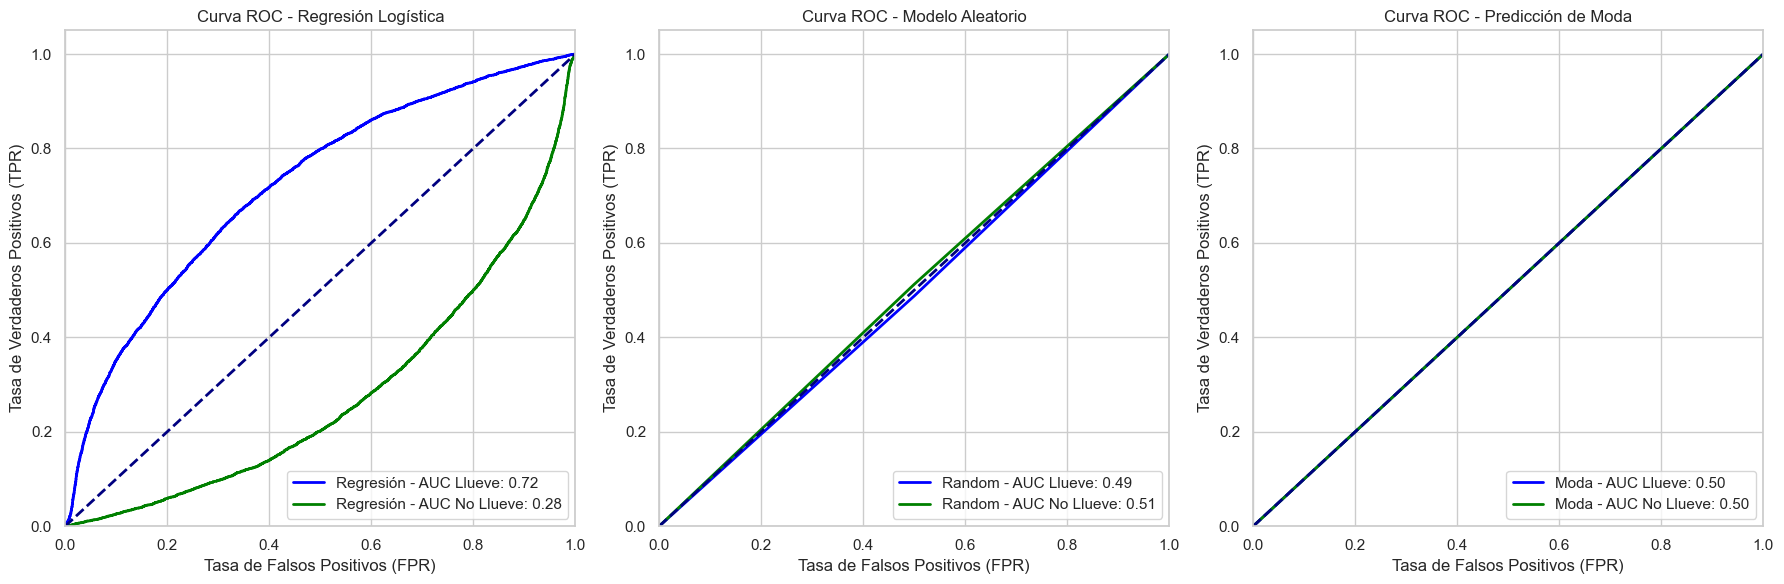

In [87]:
# Graficar las curvas ROC para los tres modelos (moda, random, regresión)
plt.figure(figsize=(18, 6))

# Subplot 1: Curva ROC para el modelo de regresión logística
plt.subplot(1, 3, 1)
plt.plot(fpr_regresion, tpr_regresion, color='blue', lw=2, label=f'Regresión - AUC Llueve: {roc_auc_regresion:.2f}')
plt.plot(fpr_regresion_no_llueve, tpr_regresion_llueve, color='green', lw=2, label=f'Regresión - AUC No Llueve: {roc_auc_regresion_no_llueve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc="lower right")

# Subplot 2: Curva ROC para el modelo aleatorio
plt.subplot(1, 3, 2)
plt.plot(fpr_random_llueve, tpr_random_llueve, color='blue', lw=2, label=f'Random - AUC Llueve: {roc_auc_random_llueve:.2f}')
plt.plot(fpr_random_no_llueve, tpr_random_no_llueve, color='green', lw=2, label=f'Random - AUC No Llueve: {roc_auc_random_no_llueve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Aleatorio')
plt.legend(loc="lower right")

# Subplot 3: Curva ROC para el modelo basado en la moda
plt.subplot(1, 3, 3)
plt.plot(fpr_moda_llueve, tpr_moda_llueve, color='blue', lw=2, label=f'Moda - AUC Llueve: {roc_auc_moda_llueve:.2f}')
plt.plot(fpr_moda_no_llueve, tpr_moda_no_llueve, color='green', lw=2, label=f'Moda - AUC No Llueve: {roc_auc_moda_no_llueve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Predicción de Moda')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


#### Umbrales para los modelos bases

El umbral estándar de 0.5 en los modelos de clasificación binaria, como la regresión logística, no siempre es el más adecuado. Este valor puede ser ajustado según sean nuestras prioridades del modelo.

Para este caso es recomendable ajustar el umbral para optimizar alguna de estas métricas como el F1-Score, precisión, o recall, según nuestro objetivo del modelo. Esto puede hacerse utilizando la curva ROC/AUC, que nos permite equilibrar entre la tasa de verdaderos positivos y falsos positivos.

En los modelos de predicción de moda y aleatorio, el ajuste de umbral no es aplicable, ya que no generan probabilidades para ajustadar.

En resumen, el umbral de 0.5 es solo un punto de partida para las clasificaciones binarias y no necesariamente el mejor para todos los problemas.

### Fitting Modelos Base Regresion Lineal, Aleatorio y Moda

* El modelo Base de Regresión lineal tiene una AUC 'Llueve'(1) de 0.72 por lo que indica que el modelo tiene la capacidad de diferenciar entre dias de 'Llueve'(1) y dias que 'No llueve'(0). Y tiene una AUC 'No llueve'(0) de 0.28, lo que demuestra que el modelo tiene problemas para detectar esta clase.

* El modelo basado en la aleatoriedad, como era de esperarde devuelve una AUC de casi 0.50 para ambas clases. Lo que significa que este modelo no tiene ningun poder predictivo y no sabe diferenciar entre las dos clases.

* El modelo basado en la moda predice unicamente la clase mayoritaria('No llueve'). Esto muestra la AUC de 0.50 para ambas clases lo que significa que este modelo no tiene ningun poder predictivo y no sabe diferenciar entre las dos clases.


# Punto 4

### Optimización de parámetros

En la regresión logística, varios hiperparámetros pueden ser optimizados para mejorar el rendimiento del modelo. Aquí hay algunos de los más comunes:

- C (inversa de la regularización): Este hiperparámetro controla la regularización en el modelo. Un valor más pequeño de 𝐶 implica más regularización (menos complejidad del modelo), mientras que un valor más grande significa menos regularización.
- penalty (tipo de regularización): Puede ser 'l1' (Lasso), 'l2' (Ridge) o 'elasticnet' (combinación de L1 y L2). La regularización ayuda a prevenir el sobreajuste al penalizar coeficientes grandes.
- max_iter (número máximo de iteraciones): Establece el número máximo de iteraciones para el algoritmo de optimización. Aumentar este número puede ayudar si el modelo no converge.
- class_weight: Permite ajustar el peso de las clases en problemas de clasificación desbalanceada. Puede ser 'balanced' o un diccionario que especifique pesos para cada clase.

In [101]:
# Definir el espacio de hiperparámetros
param_grid = {
    'C': np.logspace(-5, 5, num=100),  # Valores de C en escala logarítmica
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': range(100, 1001),  # 1000 es el valor máximo incluido
    'class_weight': ['balanced', None]
}

### K-folds

In [89]:
# Definir el modelo
modelo = LogisticRegression()
scaler_robust = RobustScaler()
X_val_encoded_sc = scaler_robust.fit_transform(X_val_encoded,y_val_encoded)
X_test_encoded_sc = scaler_robust.transform(X_test_encoded)
# Configurar la validación cruzada k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [90]:
X_val_encoded_sc = scaler_robust.fit_transform(X_val_encoded,y_val_encoded)
X_test_encoded_sc = scaler_robust.transform(X_test_encoded)

### GridSearch

In [92]:
from sklearn.metrics import make_scorer, f1_score

In [103]:
# Utilizamos GridSearchCV para encontrar la mejor combinación de hiperparámetros
# grid_search = GridSearchCV(
#     estimator=modelo,
#     param_grid=param_grid,
#     scoring='f1',  # Usamos F1-score para balancear precisión y sensibilidad
#     cv=kf,  # Validación cruzada con 5 folds
#     # n_jobs= -1
# )

# # Reducimos el tamaño del conjunto de datos para la búsqueda de hiperparámetros (por ejemplo, usamos solo el 30% de los datos)
# X_sample = X_val_encoded.sample(frac=0.3, random_state=42)
# y_sample = y_val_encoded.loc[X_sample.index]

# # Ajustar el modelo con la muestra reducida
# grid_search.fit(X_sample, y_sample)


# # Obtener los mejores hiperparámetros
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Mejores hiperparámetros encontrados:", best_params)


KeyboardInterrupt: 

In [92]:
# trials_grid = grid_search.cv_results_
# plot_params_trials(trials_grid, 'Grid')

Se decidio reducir el conjunto de datos, porque si no la ejecucion no terminaba nunca. Lo maximo que llegue a esperar fueron 11 minutos

### Random Search

In [160]:
# Configurar Random Search
random_search = RandomizedSearchCV(
    estimator=modelo,
    param_distributions=param_grid,
    n_iter=1000,  # Número de combinaciones a probar
    scoring=make_scorer(f1_score, average='binary'),
    cv=kf,
    n_jobs=-1,
    random_state=42
)

# Ajustar el modelo a los datos de entrenamiento
random_search.fit(X_val_encoded_sc, y_val_encoded)

# Obtener los mejores hiperparámetros
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Obtener el mejor F1 score encontrado durante el ajuste
best_f1_score_random = random_search.best_score_

print("Mejores hiperparámetros encontrados:", best_params_random)
print("Mejor F1 score promedio (Random Search):", best_f1_score_random)

Mejores hiperparámetros encontrados: {'penalty': 'l2', 'max_iter': 381, 'class_weight': 'balanced', 'C': 73.90722033525775}
Mejor F1 score promedio (Random Search): 0.651979065044524


### Grafico de Random Search

In [135]:
trials_random = random_search.cv_results_

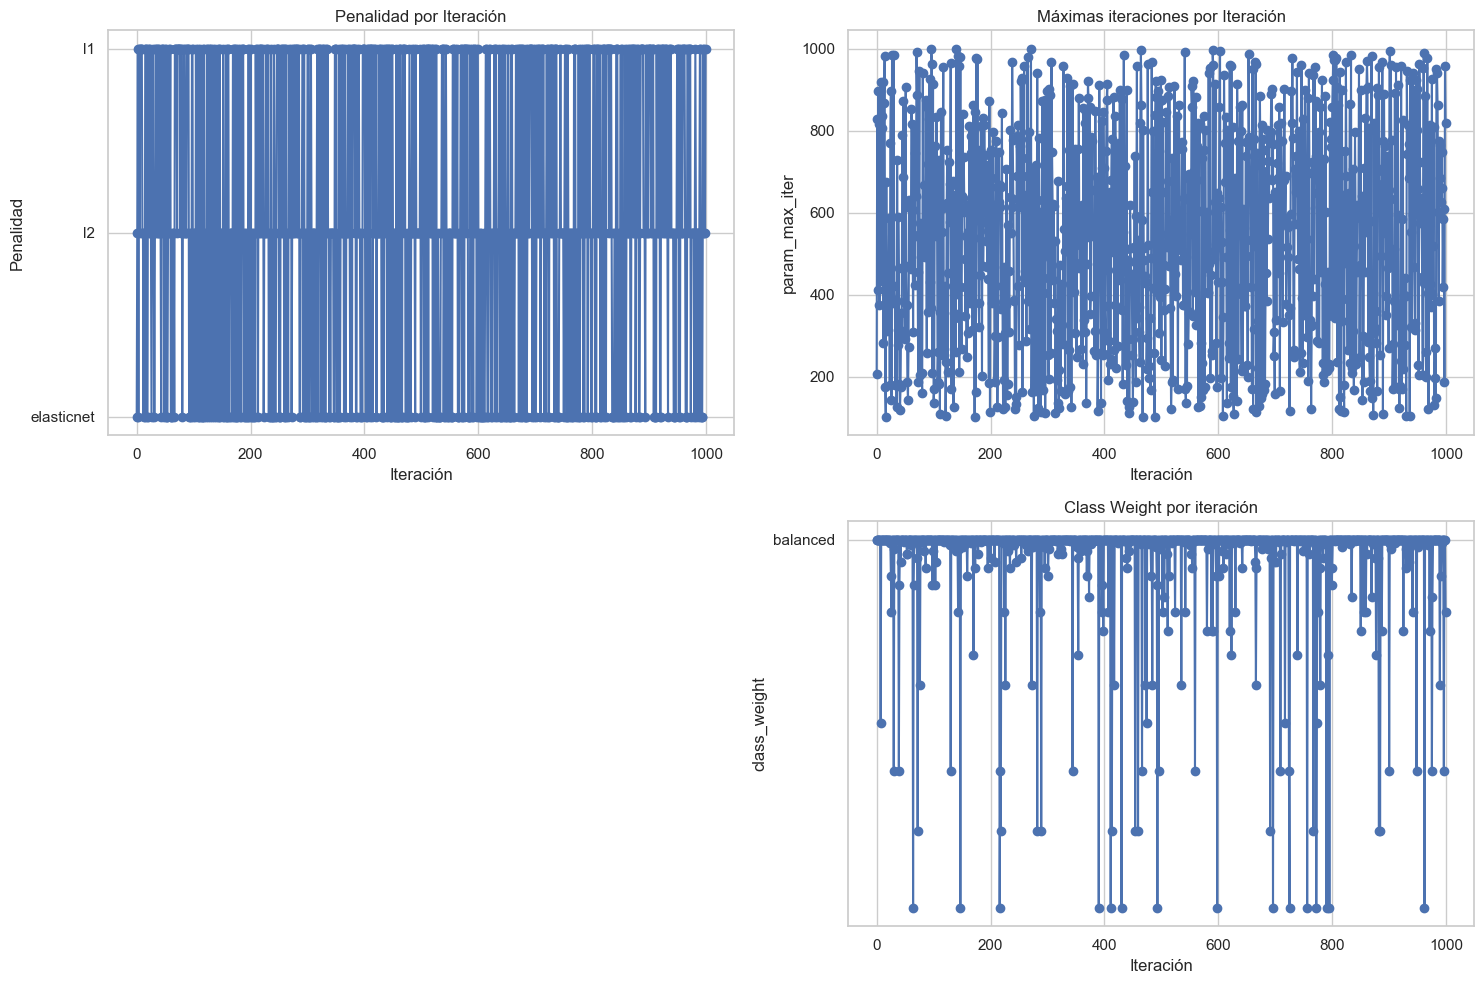

In [136]:
plot_params_trials(trials_random)

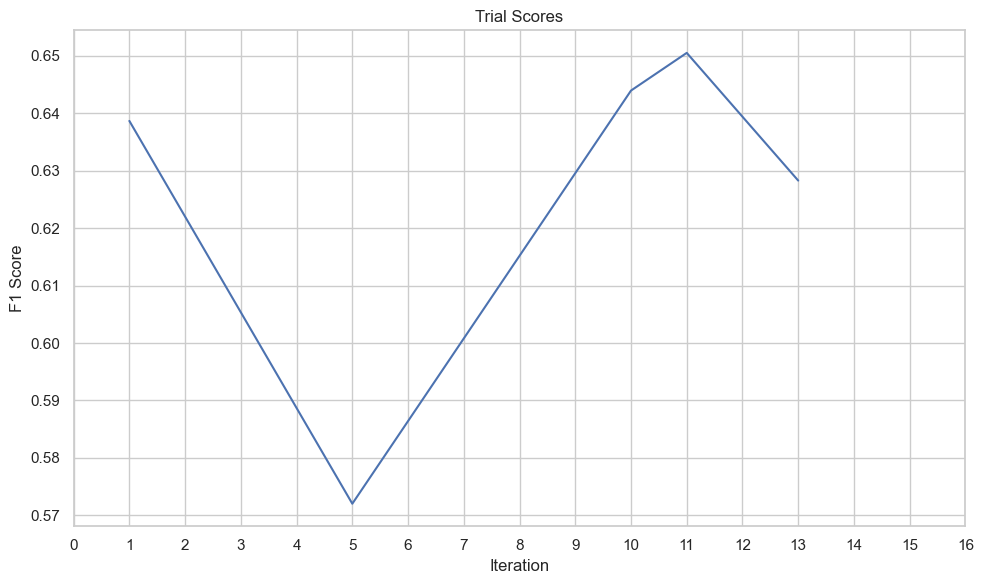

,Iteration,Params,F1 Score
0,0,"{'C': 0.0016681005372000592, 'penalty': 'elasticnet', 'max_iter': 207, 'class_weight': None}",NaN
1,1,"{'C': 0.0026560877829466868, 'penalty': 'l2', 'max_iter': 829, 'class_weight': 'balanced'}",0.638670
2,2,"{'C': 58.57020818056661, 'penalty': 'l1', 'max_iter': 411, 'class_weight': None}",NaN
3,3,"{'C': 0.5590810182512223, 'penalty': 'elasticnet', 'max_iter': 897, 'class_weight': None}",NaN
4,4,"{'C': 0.001047615752789665, 'penalty': 'l1', 'max_iter': 816, 'class_weight': 'balanced'}",NaN
5,5,"{'C': 0.00010235310218990269, 'penalty': 'l2', 'max_iter': 375, 'class_weight': 'balanced'}",0.572030
6,6,"{'C': 0.003351602650938841, 'penalty': 'l1', 'max_iter': 829, 'class_weight': 'balanced'}",NaN
7,7,"{'C': 49770.23564332114, 'penalty': 'l1', 'max_iter': 918, 'class_weight': 'balanced'}",NaN
8,8,"{'C': 0.00041320124001153346, 'penalty': 'l1', 'max_iter': 434, 'class_weight': 'balanced'}",NaN
9,9,"{'C': 0.017073526474706904, 'penalty': 'l1', 'max_iter': 837, 'class_weight': 'balanced'}",NaN


In [137]:
# Llama a la función con tus datos
plot_trials(trials_random, 'F1', 'random')

## Optuna

In [169]:
def objective(trial):
    # Definir el espacio de búsqueda para los hiperparámetros
    C = trial.suggest_loguniform('C', 1e-5, 1e5)  # Rango más amplio para C
    penalty = trial.suggest_categorical('penalty', ['l2'])  # Incluir todas las penalizaciones
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)  # Rango más amplio para max_iter

    # Crear el modelo con los hiperparámetros sugeridos
    modelo_optuna = LogisticRegression(C=C, penalty=penalty, class_weight=class_weight, max_iter=max_iter)

    f1_scorer = make_scorer(f1_score, average='binary')
    
    # Realizar validación cruzada y calcular el F1 score promedio
    f1_scores = cross_val_score(modelo_optuna, X_val_encoded_sc, y_val_encoded, cv=kf, scoring=f1_scorer)
    mean_f1 = f1_scores.mean()
    
    print(f"Trial {trial.number}: F1={mean_f1:.4f}, C={C}, penalty={penalty}, class_weight={class_weight}, max_iter={max_iter}")

    return mean_f1

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Solo un trial, ya que estamos usando los mismos hiperparámetros

best_params_optuna = study.best_params
best_value_optuna = study.best_value

print("Mejores hiperparámetros encontrados:", best_params_optuna)
print("Mejor F1-score:", best_value_optuna)


[I 2024-10-29 10:26:11,240] A new study created in memory with name: no-name-074551c7-55c8-4c93-8105-4462de9af093
[I 2024-10-29 10:26:11,574] Trial 0 finished with value: 0.6506073848653026 and parameters: {'C': 737.3299206888915, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 760}. Best is trial 0 with value: 0.6506073848653026.


Trial 0: F1=0.6506, C=737.3299206888915, penalty=l2, class_weight=balanced, max_iter=760


[I 2024-10-29 10:26:11,888] Trial 1 finished with value: 0.6298891924945196 and parameters: {'C': 6027.874608493266, 'penalty': 'l2', 'class_weight': None, 'max_iter': 133}. Best is trial 0 with value: 0.6506073848653026.
[I 2024-10-29 10:26:11,955] Trial 2 finished with value: 0.6311787511704147 and parameters: {'C': 0.0005036246673593978, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 184}. Best is trial 0 with value: 0.6506073848653026.


Trial 1: F1=0.6299, C=6027.874608493266, penalty=l2, class_weight=None, max_iter=133
Trial 2: F1=0.6312, C=0.0005036246673593978, penalty=l2, class_weight=balanced, max_iter=184


[I 2024-10-29 10:26:12,357] Trial 3 finished with value: 0.6280331410375245 and parameters: {'C': 4.5630075583828225, 'penalty': 'l2', 'class_weight': None, 'max_iter': 966}. Best is trial 0 with value: 0.6506073848653026.


Trial 3: F1=0.6280, C=4.5630075583828225, penalty=l2, class_weight=None, max_iter=966


[I 2024-10-29 10:26:12,755] Trial 4 finished with value: 0.6282854369761359 and parameters: {'C': 2563.825790065325, 'penalty': 'l2', 'class_weight': None, 'max_iter': 557}. Best is trial 0 with value: 0.6506073848653026.
[I 2024-10-29 10:26:12,817] Trial 5 finished with value: 0.18177074611450297 and parameters: {'C': 9.824741302451018e-05, 'penalty': 'l2', 'class_weight': None, 'max_iter': 726}. Best is trial 0 with value: 0.6506073848653026.


Trial 4: F1=0.6283, C=2563.825790065325, penalty=l2, class_weight=None, max_iter=557
Trial 5: F1=0.1818, C=9.824741302451018e-05, penalty=l2, class_weight=None, max_iter=726


[I 2024-10-29 10:26:13,054] Trial 6 finished with value: 0.6504881652451997 and parameters: {'C': 0.4443193048147356, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1000}. Best is trial 0 with value: 0.6506073848653026.
[I 2024-10-29 10:26:13,126] Trial 7 finished with value: 0.2660491534321337 and parameters: {'C': 0.000355254145741882, 'penalty': 'l2', 'class_weight': None, 'max_iter': 998}. Best is trial 0 with value: 0.6506073848653026.
[I 2024-10-29 10:26:13,197] Trial 8 finished with value: 0.6322101081973244 and parameters: {'C': 0.0009958362114388802, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 363}. Best is trial 0 with value: 0.6506073848653026.


Trial 6: F1=0.6505, C=0.4443193048147356, penalty=l2, class_weight=balanced, max_iter=1000
Trial 7: F1=0.2660, C=0.000355254145741882, penalty=l2, class_weight=None, max_iter=998
Trial 8: F1=0.6322, C=0.0009958362114388802, penalty=l2, class_weight=balanced, max_iter=363


[I 2024-10-29 10:26:13,563] Trial 9 finished with value: 0.6287766550533557 and parameters: {'C': 15042.878213920187, 'penalty': 'l2', 'class_weight': None, 'max_iter': 372}. Best is trial 0 with value: 0.6506073848653026.


Trial 9: F1=0.6288, C=15042.878213920187, penalty=l2, class_weight=None, max_iter=372


[I 2024-10-29 10:26:13,911] Trial 10 finished with value: 0.6507755306649969 and parameters: {'C': 26.526888032194293, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 721}. Best is trial 10 with value: 0.6507755306649969.


Trial 10: F1=0.6508, C=26.526888032194293, penalty=l2, class_weight=balanced, max_iter=721


[I 2024-10-29 10:26:14,278] Trial 11 finished with value: 0.6510009754535784 and parameters: {'C': 25.69209868099465, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 737}. Best is trial 11 with value: 0.6510009754535784.


Trial 11: F1=0.6510, C=25.69209868099465, penalty=l2, class_weight=balanced, max_iter=737


[I 2024-10-29 10:26:14,590] Trial 12 finished with value: 0.6508296531511085 and parameters: {'C': 3.9597323330574694, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 754}. Best is trial 11 with value: 0.6510009754535784.


Trial 12: F1=0.6508, C=3.9597323330574694, penalty=l2, class_weight=balanced, max_iter=754
Trial 13: F1=0.6459, C=0.05837160390295945, penalty=l2, class_weight=balanced, max_iter=812


[I 2024-10-29 10:26:14,763] Trial 13 finished with value: 0.6459315845070706 and parameters: {'C': 0.05837160390295945, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 812}. Best is trial 11 with value: 0.6510009754535784.
[I 2024-10-29 10:26:15,087] Trial 14 finished with value: 0.6504144651896487 and parameters: {'C': 180.87444459664613, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 575}. Best is trial 11 with value: 0.6510009754535784.
[I 2024-10-29 10:26:15,239] Trial 15 finished with value: 0.6444578015306827 and parameters: {'C': 0.020132408319132777, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 828}. Best is trial 11 with value: 0.6510009754535784.


Trial 14: F1=0.6504, C=180.87444459664613, penalty=l2, class_weight=balanced, max_iter=575
Trial 15: F1=0.6445, C=0.020132408319132777, penalty=l2, class_weight=balanced, max_iter=828


[I 2024-10-29 10:26:15,550] Trial 16 finished with value: 0.6511691212532726 and parameters: {'C': 25.764628798671463, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 654}. Best is trial 16 with value: 0.6511691212532726.


Trial 16: F1=0.6512, C=25.764628798671463, penalty=l2, class_weight=balanced, max_iter=654


[I 2024-10-29 10:26:15,884] Trial 17 finished with value: 0.6508008719517671 and parameters: {'C': 67484.29759291, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 613}. Best is trial 16 with value: 0.6511691212532726.


Trial 17: F1=0.6508, C=67484.29759291, penalty=l2, class_weight=balanced, max_iter=613


[I 2024-10-29 10:26:16,227] Trial 18 finished with value: 0.6515909105949615 and parameters: {'C': 62.50970539595949, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 403}. Best is trial 18 with value: 0.6515909105949615.


Trial 18: F1=0.6516, C=62.50970539595949, penalty=l2, class_weight=balanced, max_iter=403


[I 2024-10-29 10:26:16,560] Trial 19 finished with value: 0.6510009754535784 and parameters: {'C': 136.35102337950337, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 441}. Best is trial 18 with value: 0.6515909105949615.


Trial 19: F1=0.6510, C=136.35102337950337, penalty=l2, class_weight=balanced, max_iter=441
Trial 20: F1=0.6492, C=0.16356383550322073, penalty=l2, class_weight=balanced, max_iter=460


[I 2024-10-29 10:26:16,751] Trial 20 finished with value: 0.6491531426693655 and parameters: {'C': 0.16356383550322073, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 460}. Best is trial 18 with value: 0.6515909105949615.
[I 2024-10-29 10:26:17,082] Trial 21 finished with value: 0.6516133817786403 and parameters: {'C': 22.028675632336732, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 656}. Best is trial 21 with value: 0.6516133817786403.


Trial 21: F1=0.6516, C=22.028675632336732, penalty=l2, class_weight=balanced, max_iter=656


[I 2024-10-29 10:26:17,409] Trial 22 finished with value: 0.6513902370044132 and parameters: {'C': 3.7913995315318325, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 262}. Best is trial 21 with value: 0.6516133817786403.


Trial 22: F1=0.6514, C=3.7913995315318325, penalty=l2, class_weight=balanced, max_iter=262


[I 2024-10-29 10:26:17,756] Trial 23 finished with value: 0.6506549288984261 and parameters: {'C': 2.898231824944603, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 255}. Best is trial 21 with value: 0.6516133817786403.


Trial 23: F1=0.6507, C=2.898231824944603, penalty=l2, class_weight=balanced, max_iter=255


[I 2024-10-29 10:26:18,077] Trial 24 finished with value: 0.6508008719517671 and parameters: {'C': 290.3452643236963, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 275}. Best is trial 21 with value: 0.6516133817786403.
[I 2024-10-29 10:26:18,207] Trial 25 finished with value: 0.6443796177460197 and parameters: {'C': 0.010037636370915478, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 492}. Best is trial 21 with value: 0.6516133817786403.


Trial 24: F1=0.6508, C=290.3452643236963, penalty=l2, class_weight=balanced, max_iter=275
Trial 25: F1=0.6444, C=0.010037636370915478, penalty=l2, class_weight=balanced, max_iter=492


[I 2024-10-29 10:26:18,521] Trial 26 finished with value: 0.6506488330612241 and parameters: {'C': 0.6989455806839687, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 365}. Best is trial 21 with value: 0.6516133817786403.


Trial 26: F1=0.6506, C=0.6989455806839687, penalty=l2, class_weight=balanced, max_iter=365


[I 2024-10-29 10:26:18,873] Trial 27 finished with value: 0.6519528498808043 and parameters: {'C': 43.796079234000985, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 270}. Best is trial 27 with value: 0.6519528498808043.
[I 2024-10-29 10:26:18,941] Trial 28 finished with value: 0.4634692316151547 and parameters: {'C': 1.3826220531348992e-05, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 497}. Best is trial 27 with value: 0.6519528498808043.


Trial 27: F1=0.6520, C=43.796079234000985, penalty=l2, class_weight=balanced, max_iter=270
Trial 28: F1=0.4635, C=1.3826220531348992e-05, penalty=l2, class_weight=balanced, max_iter=497


[I 2024-10-29 10:26:19,246] Trial 29 finished with value: 0.6508008719517671 and parameters: {'C': 962.0792146097866, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 316}. Best is trial 27 with value: 0.6519528498808043.


Trial 29: F1=0.6508, C=962.0792146097866, penalty=l2, class_weight=balanced, max_iter=316


[I 2024-10-29 10:26:19,582] Trial 30 finished with value: 0.6506073848653026 and parameters: {'C': 62.84091136927231, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 207}. Best is trial 27 with value: 0.6519528498808043.


Trial 30: F1=0.6506, C=62.84091136927231, penalty=l2, class_weight=balanced, max_iter=207


[I 2024-10-29 10:26:19,900] Trial 31 finished with value: 0.6502430475993858 and parameters: {'C': 6.663486571269293, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 134}. Best is trial 27 with value: 0.6519528498808043.


Trial 31: F1=0.6502, C=6.663486571269293, penalty=l2, class_weight=balanced, max_iter=134


[I 2024-10-29 10:26:20,213] Trial 32 finished with value: 0.6506073848653026 and parameters: {'C': 932.7381379148753, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 418}. Best is trial 27 with value: 0.6519528498808043.


Trial 32: F1=0.6506, C=932.7381379148753, penalty=l2, class_weight=balanced, max_iter=418


[I 2024-10-29 10:26:20,532] Trial 33 finished with value: 0.6508296531511085 and parameters: {'C': 10.911827321668929, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 213}. Best is trial 27 with value: 0.6519528498808043.


Trial 33: F1=0.6508, C=10.911827321668929, penalty=l2, class_weight=balanced, max_iter=213


[I 2024-10-29 10:26:20,847] Trial 34 finished with value: 0.6299508511751089 and parameters: {'C': 1.6651627218946654, 'penalty': 'l2', 'class_weight': None, 'max_iter': 115}. Best is trial 27 with value: 0.6519528498808043.


Trial 34: F1=0.6300, C=1.6651627218946654, penalty=l2, class_weight=None, max_iter=115


[I 2024-10-29 10:26:21,213] Trial 35 finished with value: 0.6510003788148732 and parameters: {'C': 3145.303866230911, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 301}. Best is trial 27 with value: 0.6519528498808043.


Trial 35: F1=0.6510, C=3145.303866230911, penalty=l2, class_weight=balanced, max_iter=301


[I 2024-10-29 10:26:21,588] Trial 36 finished with value: 0.6282854369761359 and parameters: {'C': 76.67724502112095, 'penalty': 'l2', 'class_weight': None, 'max_iter': 236}. Best is trial 27 with value: 0.6519528498808043.


Trial 36: F1=0.6283, C=76.67724502112095, penalty=l2, class_weight=None, max_iter=236


[I 2024-10-29 10:26:21,963] Trial 37 finished with value: 0.6508883630021381 and parameters: {'C': 489.46897096734097, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 659}. Best is trial 27 with value: 0.6519528498808043.


Trial 37: F1=0.6509, C=489.46897096734097, penalty=l2, class_weight=balanced, max_iter=659


[I 2024-10-29 10:26:22,219] Trial 38 finished with value: 0.6489298067690167 and parameters: {'C': 0.2958919087624074, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 172}. Best is trial 27 with value: 0.6519528498808043.


Trial 38: F1=0.6489, C=0.2958919087624074, penalty=l2, class_weight=balanced, max_iter=172


[I 2024-10-29 10:26:22,586] Trial 39 finished with value: 0.6282854369761359 and parameters: {'C': 9188.340887297178, 'penalty': 'l2', 'class_weight': None, 'max_iter': 331}. Best is trial 27 with value: 0.6519528498808043.


Trial 39: F1=0.6283, C=9188.340887297178, penalty=l2, class_weight=None, max_iter=331


[I 2024-10-29 10:26:22,938] Trial 40 finished with value: 0.6509759077695476 and parameters: {'C': 9.123445161337132, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 396}. Best is trial 27 with value: 0.6519528498808043.


Trial 40: F1=0.6510, C=9.123445161337132, penalty=l2, class_weight=balanced, max_iter=396


[I 2024-10-29 10:26:23,282] Trial 41 finished with value: 0.6513891072458847 and parameters: {'C': 33.321941456477745, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 651}. Best is trial 27 with value: 0.6519528498808043.


Trial 41: F1=0.6514, C=33.321941456477745, penalty=l2, class_weight=balanced, max_iter=651


[I 2024-10-29 10:26:23,671] Trial 42 finished with value: 0.6502221104325181 and parameters: {'C': 51.543084172066415, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 533}. Best is trial 27 with value: 0.6519528498808043.


Trial 42: F1=0.6502, C=51.543084172066415, penalty=l2, class_weight=balanced, max_iter=533


[I 2024-10-29 10:26:23,988] Trial 43 finished with value: 0.6510382029048121 and parameters: {'C': 1.0794394738608566, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 684}. Best is trial 27 with value: 0.6519528498808043.


Trial 43: F1=0.6510, C=1.0794394738608566, penalty=l2, class_weight=balanced, max_iter=684


[I 2024-10-29 10:26:24,333] Trial 44 finished with value: 0.6507755306649969 and parameters: {'C': 18.81633607928032, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 585}. Best is trial 27 with value: 0.6519528498808043.


Trial 44: F1=0.6508, C=18.81633607928032, penalty=l2, class_weight=balanced, max_iter=585


[I 2024-10-29 10:26:24,683] Trial 45 finished with value: 0.6280575801679015 and parameters: {'C': 1.7648193225424704, 'penalty': 'l2', 'class_weight': None, 'max_iter': 620}. Best is trial 27 with value: 0.6519528498808043.


Trial 45: F1=0.6281, C=1.7648193225424704, penalty=l2, class_weight=None, max_iter=620


[I 2024-10-29 10:26:24,999] Trial 46 finished with value: 0.6509690177514613 and parameters: {'C': 160.04444279708574, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 835}. Best is trial 27 with value: 0.6519528498808043.


Trial 46: F1=0.6510, C=160.04444279708574, penalty=l2, class_weight=balanced, max_iter=835


[I 2024-10-29 10:26:25,318] Trial 47 finished with value: 0.6504397094035094 and parameters: {'C': 1737.4799626936922, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 522}. Best is trial 27 with value: 0.6519528498808043.


Trial 47: F1=0.6504, C=1737.4799626936922, penalty=l2, class_weight=balanced, max_iter=522


[I 2024-10-29 10:26:25,641] Trial 48 finished with value: 0.6504146070705537 and parameters: {'C': 4.909156184417476, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 161}. Best is trial 27 with value: 0.6519528498808043.


Trial 48: F1=0.6504, C=4.909156184417476, penalty=l2, class_weight=balanced, max_iter=161


[I 2024-10-29 10:26:25,848] Trial 49 finished with value: 0.6478124925284718 and parameters: {'C': 0.10467041328840243, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 279}. Best is trial 27 with value: 0.6519528498808043.


Trial 49: F1=0.6478, C=0.10467041328840243, penalty=l2, class_weight=balanced, max_iter=279


[I 2024-10-29 10:26:26,252] Trial 50 finished with value: 0.6282854369761359 and parameters: {'C': 35.91950569118151, 'penalty': 'l2', 'class_weight': None, 'max_iter': 787}. Best is trial 27 with value: 0.6519528498808043.


Trial 50: F1=0.6283, C=35.91950569118151, penalty=l2, class_weight=None, max_iter=787


[I 2024-10-29 10:26:26,587] Trial 51 finished with value: 0.6507755306649969 and parameters: {'C': 17.428304724131316, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 690}. Best is trial 27 with value: 0.6519528498808043.


Trial 51: F1=0.6508, C=17.428304724131316, penalty=l2, class_weight=balanced, max_iter=690


[I 2024-10-29 10:26:26,936] Trial 52 finished with value: 0.6505859293730234 and parameters: {'C': 77.41832179416997, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 627}. Best is trial 27 with value: 0.6519528498808043.


Trial 52: F1=0.6506, C=77.41832179416997, penalty=l2, class_weight=balanced, max_iter=627


[I 2024-10-29 10:26:27,282] Trial 53 finished with value: 0.6511691212532726 and parameters: {'C': 233.54504580005883, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 654}. Best is trial 27 with value: 0.6519528498808043.


Trial 53: F1=0.6512, C=233.54504580005883, penalty=l2, class_weight=balanced, max_iter=654


[I 2024-10-29 10:26:27,626] Trial 54 finished with value: 0.6513934135071887 and parameters: {'C': 16.209184198631743, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 710}. Best is trial 27 with value: 0.6519528498808043.


Trial 54: F1=0.6514, C=16.209184198631743, penalty=l2, class_weight=balanced, max_iter=710


[I 2024-10-29 10:26:27,937] Trial 55 finished with value: 0.6506019589469799 and parameters: {'C': 2.656592115410109, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 884}. Best is trial 27 with value: 0.6519528498808043.


Trial 55: F1=0.6506, C=2.656592115410109, penalty=l2, class_weight=balanced, max_iter=884


[I 2024-10-29 10:26:28,190] Trial 56 finished with value: 0.6504881652451997 and parameters: {'C': 0.48242417294916684, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 721}. Best is trial 27 with value: 0.6519528498808043.


Trial 56: F1=0.6505, C=0.48242417294916684, penalty=l2, class_weight=balanced, max_iter=721


[I 2024-10-29 10:26:28,531] Trial 57 finished with value: 0.6516133817786403 and parameters: {'C': 11.275357983035354, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 768}. Best is trial 27 with value: 0.6519528498808043.


Trial 57: F1=0.6516, C=11.275357983035354, penalty=l2, class_weight=balanced, max_iter=768


[I 2024-10-29 10:26:28,861] Trial 58 finished with value: 0.6506073848653026 and parameters: {'C': 10.920634377517562, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 896}. Best is trial 27 with value: 0.6519528498808043.


Trial 58: F1=0.6506, C=10.920634377517562, penalty=l2, class_weight=balanced, max_iter=896


[I 2024-10-29 10:26:29,220] Trial 59 finished with value: 0.6513934135071887 and parameters: {'C': 389.75537457621937, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 750}. Best is trial 27 with value: 0.6519528498808043.


Trial 59: F1=0.6514, C=389.75537457621937, penalty=l2, class_weight=balanced, max_iter=750


[I 2024-10-29 10:26:29,604] Trial 60 finished with value: 0.6504144651896487 and parameters: {'C': 415.4951697879867, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 780}. Best is trial 27 with value: 0.6519528498808043.


Trial 60: F1=0.6504, C=415.4951697879867, penalty=l2, class_weight=balanced, max_iter=780


[I 2024-10-29 10:26:29,905] Trial 61 finished with value: 0.6506073848653026 and parameters: {'C': 99.47766293599537, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 747}. Best is trial 27 with value: 0.6519528498808043.


Trial 61: F1=0.6506, C=99.47766293599537, penalty=l2, class_weight=balanced, max_iter=747


[I 2024-10-29 10:26:30,287] Trial 62 finished with value: 0.6513934135071887 and parameters: {'C': 28089.261397098933, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 696}. Best is trial 27 with value: 0.6519528498808043.


Trial 62: F1=0.6514, C=28089.261397098933, penalty=l2, class_weight=balanced, max_iter=696


[I 2024-10-29 10:26:30,630] Trial 63 finished with value: 0.65178470408111 and parameters: {'C': 4225.411099144057, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 700}. Best is trial 27 with value: 0.6519528498808043.


Trial 63: F1=0.6518, C=4225.411099144057, penalty=l2, class_weight=balanced, max_iter=700


[I 2024-10-29 10:26:30,939] Trial 64 finished with value: 0.6509732035864343 and parameters: {'C': 4787.312833166949, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 784}. Best is trial 27 with value: 0.6519528498808043.


Trial 64: F1=0.6510, C=4787.312833166949, penalty=l2, class_weight=balanced, max_iter=784


[I 2024-10-29 10:26:31,282] Trial 65 finished with value: 0.6513902370044132 and parameters: {'C': 2005.9989399042165, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 715}. Best is trial 27 with value: 0.6519528498808043.


Trial 65: F1=0.6514, C=2005.9989399042165, penalty=l2, class_weight=balanced, max_iter=715


[I 2024-10-29 10:26:31,606] Trial 66 finished with value: 0.6511691212532726 and parameters: {'C': 18789.510028813653, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 855}. Best is trial 27 with value: 0.6519528498808043.


Trial 66: F1=0.6512, C=18789.510028813653, penalty=l2, class_weight=balanced, max_iter=855


[I 2024-10-29 10:26:31,938] Trial 67 finished with value: 0.6511691212532726 and parameters: {'C': 1038.8116626268213, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 942}. Best is trial 27 with value: 0.6519528498808043.


Trial 67: F1=0.6512, C=1038.8116626268213, penalty=l2, class_weight=balanced, max_iter=942


[I 2024-10-29 10:26:32,306] Trial 68 finished with value: 0.6515909105949615 and parameters: {'C': 372.11301128236397, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 578}. Best is trial 27 with value: 0.6519528498808043.


Trial 68: F1=0.6516, C=372.11301128236397, penalty=l2, class_weight=balanced, max_iter=578


[I 2024-10-29 10:26:32,681] Trial 69 finished with value: 0.628313882194178 and parameters: {'C': 81736.31291698056, 'penalty': 'l2', 'class_weight': None, 'max_iter': 593}. Best is trial 27 with value: 0.6519528498808043.


Trial 69: F1=0.6283, C=81736.31291698056, penalty=l2, class_weight=None, max_iter=593


[I 2024-10-29 10:26:33,022] Trial 70 finished with value: 0.6502221104325181 and parameters: {'C': 116.99172389964156, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 560}. Best is trial 27 with value: 0.6519528498808043.


Trial 70: F1=0.6502, C=116.99172389964156, penalty=l2, class_weight=balanced, max_iter=560


[I 2024-10-29 10:26:33,338] Trial 71 finished with value: 0.6504144651896487 and parameters: {'C': 704.7530168139854, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 759}. Best is trial 27 with value: 0.6519528498808043.


Trial 71: F1=0.6504, C=704.7530168139854, penalty=l2, class_weight=balanced, max_iter=759


[I 2024-10-29 10:26:33,681] Trial 72 finished with value: 0.6507755306649969 and parameters: {'C': 302.1381581560773, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 482}. Best is trial 27 with value: 0.6519528498808043.


Trial 72: F1=0.6508, C=302.1381581560773, penalty=l2, class_weight=balanced, max_iter=482


[I 2024-10-29 10:26:34,020] Trial 73 finished with value: 0.6506073848653026 and parameters: {'C': 45.055070611418614, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 801}. Best is trial 27 with value: 0.6519528498808043.


Trial 73: F1=0.6506, C=45.055070611418614, penalty=l2, class_weight=balanced, max_iter=801


[I 2024-10-29 10:26:34,305] Trial 74 finished with value: 0.6509692920053609 and parameters: {'C': 17.419702444846397, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 730}. Best is trial 27 with value: 0.6519528498808043.


Trial 74: F1=0.6510, C=17.419702444846397, penalty=l2, class_weight=balanced, max_iter=730


[I 2024-10-29 10:26:34,634] Trial 75 finished with value: 0.650582610989343 and parameters: {'C': 6856.971204761681, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 683}. Best is trial 27 with value: 0.6519528498808043.


Trial 75: F1=0.6506, C=6856.971204761681, penalty=l2, class_weight=balanced, max_iter=683


[I 2024-10-29 10:26:34,966] Trial 76 finished with value: 0.6500838500535548 and parameters: {'C': 216.14269874098565, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 342}. Best is trial 27 with value: 0.6519528498808043.


Trial 76: F1=0.6501, C=216.14269874098565, penalty=l2, class_weight=balanced, max_iter=342


[I 2024-10-29 10:26:35,301] Trial 77 finished with value: 0.6516181414500808 and parameters: {'C': 7.288381076401525, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 608}. Best is trial 27 with value: 0.6519528498808043.


Trial 77: F1=0.6516, C=7.288381076401525, penalty=l2, class_weight=balanced, max_iter=608


[I 2024-10-29 10:26:35,631] Trial 78 finished with value: 0.6517556315172023 and parameters: {'C': 6.752730162773905, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 606}. Best is trial 27 with value: 0.6519528498808043.


Trial 78: F1=0.6518, C=6.752730162773905, penalty=l2, class_weight=balanced, max_iter=606


[I 2024-10-29 10:26:35,973] Trial 79 finished with value: 0.6517556315172023 and parameters: {'C': 7.516585845773145, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 605}. Best is trial 27 with value: 0.6519528498808043.


Trial 79: F1=0.6518, C=7.516585845773145, penalty=l2, class_weight=balanced, max_iter=605


[I 2024-10-29 10:26:36,278] Trial 80 finished with value: 0.6506073848653026 and parameters: {'C': 6.096719127767941, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 545}. Best is trial 27 with value: 0.6519528498808043.


Trial 80: F1=0.6506, C=6.096719127767941, penalty=l2, class_weight=balanced, max_iter=545


[I 2024-10-29 10:26:36,570] Trial 81 finished with value: 0.6510471252595132 and parameters: {'C': 1.1395842143048804, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 601}. Best is trial 27 with value: 0.6519528498808043.


Trial 81: F1=0.6510, C=1.1395842143048804, penalty=l2, class_weight=balanced, max_iter=601


[I 2024-10-29 10:26:36,874] Trial 82 finished with value: 0.6508434366013847 and parameters: {'C': 3.0563218590185475, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 631}. Best is trial 27 with value: 0.6519528498808043.


Trial 82: F1=0.6508, C=3.0563218590185475, penalty=l2, class_weight=balanced, max_iter=631


[I 2024-10-29 10:26:37,209] Trial 83 finished with value: 0.6506073848653026 and parameters: {'C': 10.36096067313766, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 567}. Best is trial 27 with value: 0.6519528498808043.


Trial 83: F1=0.6506, C=10.36096067313766, penalty=l2, class_weight=balanced, max_iter=567


[I 2024-10-29 10:26:37,536] Trial 84 finished with value: 0.6509690177514613 and parameters: {'C': 31.618108537675923, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 521}. Best is trial 27 with value: 0.6519528498808043.


Trial 84: F1=0.6510, C=31.618108537675923, penalty=l2, class_weight=balanced, max_iter=521


[I 2024-10-29 10:26:37,915] Trial 85 finished with value: 0.6282854369761359 and parameters: {'C': 6.900752102488913, 'penalty': 'l2', 'class_weight': None, 'max_iter': 453}. Best is trial 27 with value: 0.6519528498808043.


Trial 85: F1=0.6283, C=6.900752102488913, penalty=l2, class_weight=None, max_iter=453


[I 2024-10-29 10:26:38,256] Trial 86 finished with value: 0.6508332999917852 and parameters: {'C': 53.86697536739483, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 645}. Best is trial 27 with value: 0.6519528498808043.


Trial 86: F1=0.6508, C=53.86697536739483, penalty=l2, class_weight=balanced, max_iter=645


[I 2024-10-29 10:26:38,583] Trial 87 finished with value: 0.6512405804357614 and parameters: {'C': 2.6099184807872517, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 665}. Best is trial 27 with value: 0.6519528498808043.
[I 2024-10-29 10:26:38,680] Trial 88 finished with value: 0.6344571611213412 and parameters: {'C': 0.0017891343548424644, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 599}. Best is trial 27 with value: 0.6519528498808043.


Trial 87: F1=0.6512, C=2.6099184807872517, penalty=l2, class_weight=balanced, max_iter=665
Trial 88: F1=0.6345, C=0.0017891343548424644, penalty=l2, class_weight=balanced, max_iter=599


[I 2024-10-29 10:26:38,993] Trial 89 finished with value: 0.6507755306649969 and parameters: {'C': 135.17830934811653, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 579}. Best is trial 27 with value: 0.6519528498808043.


Trial 89: F1=0.6508, C=135.17830934811653, penalty=l2, class_weight=balanced, max_iter=579


[I 2024-10-29 10:26:39,301] Trial 90 finished with value: 0.6510093561439729 and parameters: {'C': 0.6053643735278391, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 420}. Best is trial 27 with value: 0.6519528498808043.


Trial 90: F1=0.6510, C=0.6053643735278391, penalty=l2, class_weight=balanced, max_iter=420


[I 2024-10-29 10:26:39,624] Trial 91 finished with value: 0.6509690177514613 and parameters: {'C': 20.268077579036117, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 706}. Best is trial 27 with value: 0.6519528498808043.


Trial 91: F1=0.6510, C=20.268077579036117, penalty=l2, class_weight=balanced, max_iter=706


[I 2024-10-29 10:26:39,952] Trial 92 finished with value: 0.6506073848653026 and parameters: {'C': 13.347100468319576, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 620}. Best is trial 27 with value: 0.6519528498808043.


Trial 92: F1=0.6506, C=13.347100468319576, penalty=l2, class_weight=balanced, max_iter=620


[I 2024-10-29 10:26:40,330] Trial 93 finished with value: 0.6517894637525505 and parameters: {'C': 4.737143842286811, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 639}. Best is trial 27 with value: 0.6519528498808043.


Trial 93: F1=0.6518, C=4.737143842286811, penalty=l2, class_weight=balanced, max_iter=639


[I 2024-10-29 10:26:40,655] Trial 94 finished with value: 0.6502464612708593 and parameters: {'C': 4.634735593317073, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 669}. Best is trial 27 with value: 0.6519528498808043.


Trial 94: F1=0.6502, C=4.634735593317073, penalty=l2, class_weight=balanced, max_iter=669


[I 2024-10-29 10:26:40,947] Trial 95 finished with value: 0.6492901964525396 and parameters: {'C': 0.3148918371337393, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 512}. Best is trial 27 with value: 0.6519528498808043.


Trial 95: F1=0.6493, C=0.3148918371337393, penalty=l2, class_weight=balanced, max_iter=512


[I 2024-10-29 10:26:41,270] Trial 96 finished with value: 0.6509982735488161 and parameters: {'C': 1.9900996610619637, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 638}. Best is trial 27 with value: 0.6519528498808043.


Trial 96: F1=0.6510, C=1.9900996610619637, penalty=l2, class_weight=balanced, max_iter=638


[I 2024-10-29 10:26:41,615] Trial 97 finished with value: 0.6519930227589957 and parameters: {'C': 1.0909460726887812, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 569}. Best is trial 97 with value: 0.6519930227589957.


Trial 97: F1=0.6520, C=1.0909460726887812, penalty=l2, class_weight=balanced, max_iter=569


[I 2024-10-29 10:26:41,958] Trial 98 finished with value: 0.630687001636398 and parameters: {'C': 0.8178527932902009, 'penalty': 'l2', 'class_weight': None, 'max_iter': 550}. Best is trial 97 with value: 0.6519930227589957.


Trial 98: F1=0.6307, C=0.8178527932902009, penalty=l2, class_weight=None, max_iter=550


[I 2024-10-29 10:26:42,260] Trial 99 finished with value: 0.6512283545633805 and parameters: {'C': 1.2133396335212052, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 673}. Best is trial 97 with value: 0.6519930227589957.


Trial 99: F1=0.6512, C=1.2133396335212052, penalty=l2, class_weight=balanced, max_iter=673
Mejores hiperparámetros encontrados: {'C': 1.0909460726887812, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 569}
Mejor F1-score: 0.6519930227589957


In [170]:
trials_optuna = study.trials
C = [trial.params['C'] for trial in trials_optuna]

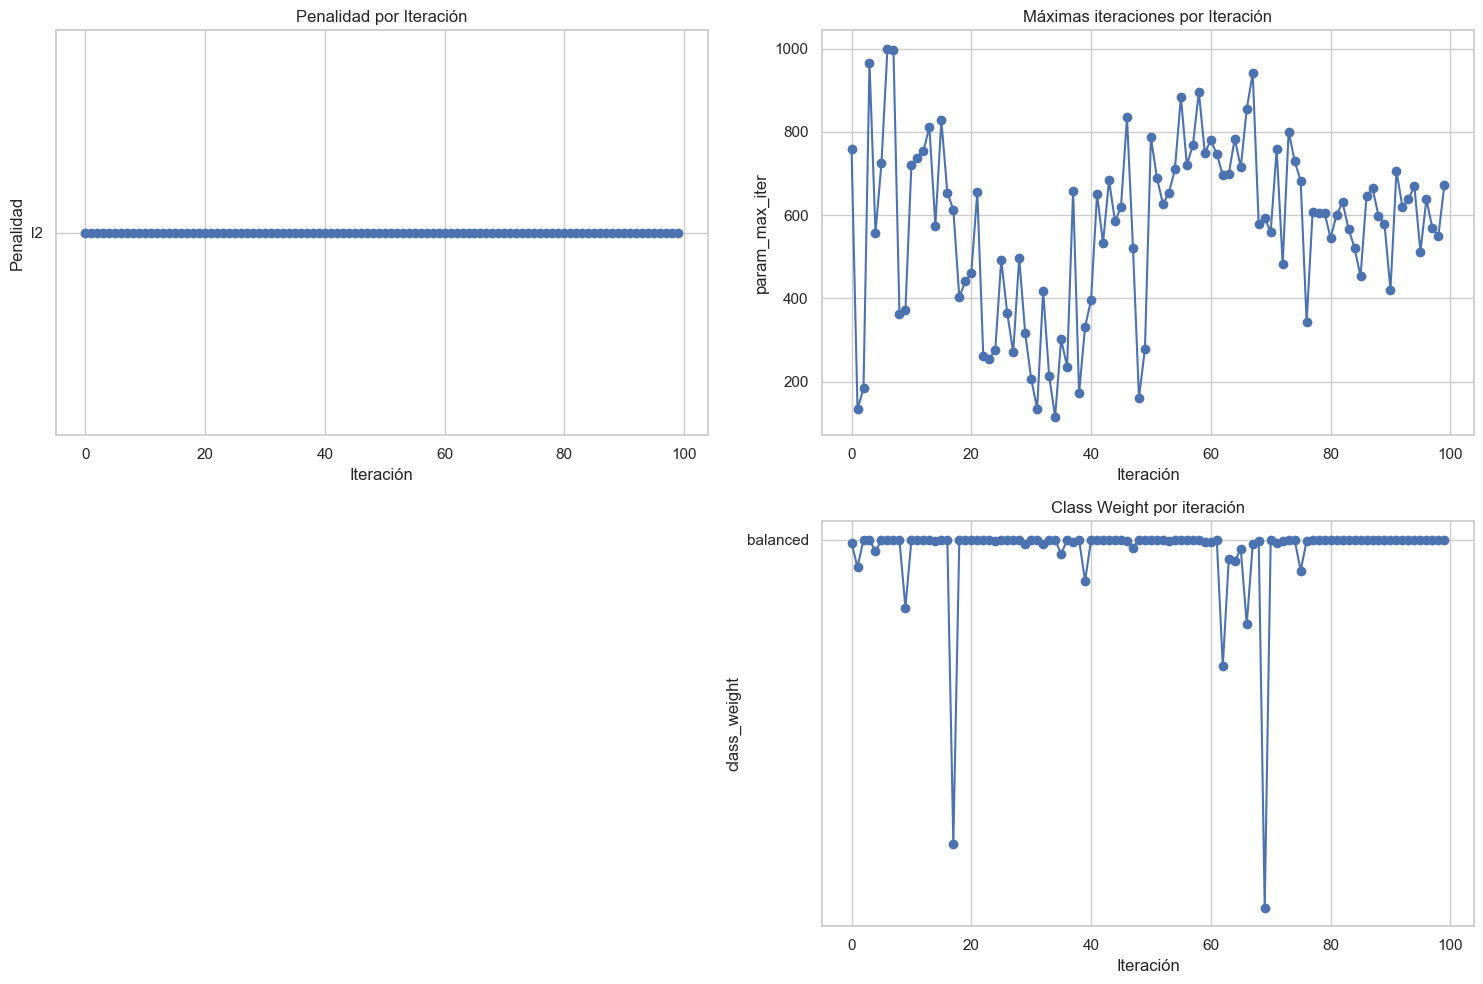

In [171]:
plot_params_trials(trials_optuna, 'Optuna')

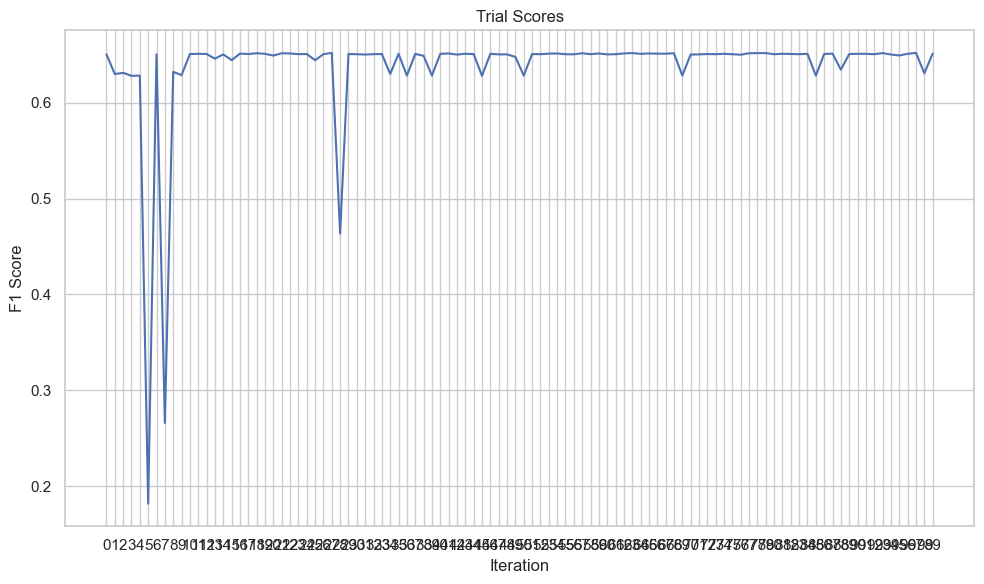

,Iteration,Params,F1 Score
0,0,"{'C': 737.3299206888915, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 760}",0.650607
1,1,"{'C': 6027.874608493266, 'penalty': 'l2', 'class_weight': None, 'max_iter': 133}",0.629889
2,2,"{'C': 0.0005036246673593978, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 184}",0.631179
3,3,"{'C': 4.5630075583828225, 'penalty': 'l2', 'class_weight': None, 'max_iter': 966}",0.628033
4,4,"{'C': 2563.825790065325, 'penalty': 'l2', 'class_weight': None, 'max_iter': 557}",0.628285
...,...,...,...
95,95,"{'C': 0.3148918371337393, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 512}",0.649290
96,96,"{'C': 1.9900996610619637, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 638}",0.650998
97,97,"{'C': 1.0909460726887812, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 569}",0.651993
98,98,"{'C': 0.8178527932902009, 'penalty': 'l2', 'class_weight': None, 'max_iter': 550}",0.630687


In [172]:
# Llama a la función con tus datos
plot_trials(trials_optuna, 'F1', 'optuna')

Luego de usar y analizar estas 3 tecnicas de optimizacion de hiperparametros, podemos decir que:
* **Grid Search** no nos conviene, pues este mismo se usa cuando hay un espacio de hiperparametros mas pequeños, y cuando se busca una solucion rapida, el cual no es nuestro caso.
* **Random Search** es mas eficiente, pues puede encontrar buenas combinacines mas rapido que Grid Search. Péro una de sus desventajas es que no garantiza que se evaluen todas las combinaciones, por lo que puede llegar a pasar por alto la mejor configuracion.
* Y por ultimo **Optuna**, la cual utiliza un enfoque mucho mas inteligente para explorar el espacio de hiperparametros, lo que resulta en una optimizacion mas rapida y efectiva. Otra ventaja es que tiene un manejo de espacio complejos efectivo.

Entonces la tecnica de optimizacion de hiperparametros que mas nos conviene usar es **Optuna**

Los hiperparametros a optimizar son los siguientes:
- **`n_estimators`**: Número de árboles en el bosque. Aumentar este número puede mejorar la precisión, pero también incrementa el tiempo de entrenamiento. En nuestro caso, el valor mas optimo seria alrededor de los 120-170, el cual es un rango comun.

- **`max_depth`**: Profundidad máxima de los árboles. Limitar la profundidad puede ayudar a prevenir el sobreajuste. En nuestro caso, el valor mas optimo suele ser None, o oscila entre 10-30.

- **`min_samples_split`**: Número mínimo de muestras necesarias para dividir un nodo. Aumentar este valor puede ayudar a prevenir el sobreajuste. En nuestro caso el valor mas optimo estaria entre 5-10.

- **`min_samples_leaf`**: Número mínimo de muestras que debe tener un nodo hoja. Esto también puede ayudar a prevenir el sobreajuste. En nuestro caso el valor mas optimo estaria entre 1-5.

In [190]:
best_value_optuna , best_params_optuna

(0.6519930227589957,
 {'C': 1.0909460726887812,
  'penalty': 'l2',
  'class_weight': 'balanced',
  'max_iter': 569})

In [191]:
random_search.best_score_, best_params_random

(0.651979065044524,
 {'penalty': 'l2',
  'max_iter': 381,
  'class_weight': 'balanced',
  'C': 73.90722033525775})

# Modelo con mejores Hiperparámetros para F1-Score

In [193]:
C_op = best_params_optuna['C']
class_w = best_params_optuna['class_weight']
max_iters = best_params_optuna['max_iter']

best_model_optuna = make_pipeline(RobustScaler(), LogisticRegression(penalty = 'l2', max_iter = max_iters, C= C_op,class_weight =class_w))


In [194]:
best_model_optuna.fit(X_train_encoded, y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=1.0909460726887812,
                                    class_weight='balanced', max_iter=569))])

# Punto 4

In [195]:
from sklearn.metrics import classification_report
import shap

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [197]:
np.random.seed(10)
shap.initjs()

In [198]:
model_random = make_pipeline(RobustScaler(), best_model_random)

In [199]:
model_random

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=73.90722033525775,
                                    class_weight='balanced', max_iter=381))])

In [200]:
model_random.fit(X_train_encoded,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=73.90722033525775,
                                    class_weight='balanced', max_iter=381))])

In [201]:
X_train_encoded

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,sin_day,cos_day,sin_WindGustDir,cos_WindGustDir,sin_WindDir9am,cos_WindDir9am,sin_WindDir3pm,cos_WindDir3pm,Latitude,Longitude
39538,15.2,34.0,0.0,11.6,9.2,41.0,17.0,20.0,62.0,36.0,...,0.017213,0.999852,-7.071068e-01,7.071068e-01,-9.238795e-01,0.382683,7.071068e-01,-7.071068e-01,-32.808997,151.838997
39539,18.3,24.5,0.0,8.8,9.4,54.0,13.0,30.0,61.0,57.0,...,0.034422,0.999407,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000,1.000000e+00,6.123234e-17,-32.808997,151.838997
39540,16.8,23.5,0.4,8.4,0.4,37.0,19.0,22.0,60.0,58.0,...,0.051620,0.998667,7.071068e-01,7.071068e-01,9.238795e-01,-0.382683,9.238795e-01,3.826834e-01,-32.808997,151.838997
39541,17.5,27.8,0.0,5.0,12.0,50.0,19.0,35.0,60.0,51.0,...,0.068802,0.997630,1.000000e+00,6.123234e-17,7.071068e-01,0.707107,9.238795e-01,3.826834e-01,-32.808997,151.838997
39542,14.8,36.0,0.0,8.6,11.9,37.0,15.0,26.0,67.0,39.0,...,0.085965,0.996298,9.238795e-01,3.826834e-01,-3.826834e-01,0.923880,9.238795e-01,3.826834e-01,-32.808997,151.838997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82293,5.4,12.7,8.6,2.6,2.9,43.0,2.0,15.0,82.0,73.0,...,-0.741222,-0.671260,-3.826834e-01,-9.238795e-01,-7.071068e-01,-0.707107,1.224647e-16,-1.000000e+00,-37.914390,141.273000
82294,7.2,13.0,1.0,0.6,0.6,28.0,9.0,17.0,100.0,87.0,...,-0.752667,-0.658402,-9.238795e-01,-3.826834e-01,-3.826834e-01,0.923880,-9.238795e-01,-3.826834e-01,-37.914390,141.273000
82295,6.8,14.8,1.0,1.0,5.3,39.0,11.0,19.0,100.0,71.0,...,-0.763889,-0.645348,0.000000e+00,1.000000e+00,0.000000e+00,1.000000,3.826834e-01,9.238795e-01,-37.914390,141.273000
82296,8.0,12.4,0.6,2.8,2.7,41.0,26.0,13.0,87.0,90.0,...,-0.774884,-0.632103,-1.000000e+00,-1.836970e-16,3.826834e-01,0.923880,0.000000e+00,1.000000e+00,-37.914390,141.273000


In [202]:
explainer = shap.Explainer(
    best_model_random, X_train_encoded, feature_names=list(X_train_encoded.columns)
)
shap_values = explainer(X_test_encoded)

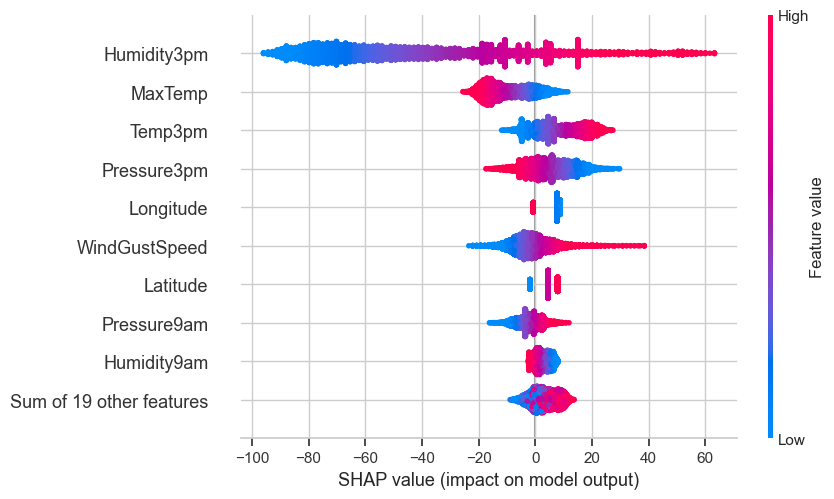

In [203]:
shap.plots.beeswarm(shap_values)

In [204]:
ind_1 = 0
shap.initjs()
shap.plots.force(shap_values[ind_1])

In [205]:
print('Llueve.' if y_test_encoded.iloc[ind_1] == 1 else 'No llueve.', 'Caso:')
X_test.iloc[ind_1]

No llueve. Caso:


Location         Launceston
MinTemp                 4.3
MaxTemp                17.4
Rainfall                0.0
Evaporation             2.2
Sunshine                6.0
WindGustDir              NW
WindGustSpeed          24.0
WindDir9am              WNW
WindDir3pm               NW
WindSpeed9am            0.0
WindSpeed3pm           13.0
Humidity9am            92.0
Humidity3pm            57.0
Pressure9am          1019.1
Pressure3pm          1016.9
Cloud9am                8.0
Cloud3pm                7.0
Temp9am                 8.0
Temp3pm                16.4
RainToday                No
Day_of_Year             240
Name: 135038, dtype: object

In [206]:
ind_2 = 4
shap.initjs()
shap.plots.force(shap_values[ind_2])

In [207]:
print('Llueve.' if y_test_encoded.iloc[ind_2] == 1 else 'No llueve.', 'Caso:')
X_test.iloc[ind_2]

Llueve. Caso:


Location         Launceston
MinTemp                 8.3
MaxTemp                13.8
Rainfall                0.4
Evaporation             3.0
Sunshine                6.9
WindGustDir              SE
WindGustSpeed          50.0
WindDir9am              NNW
WindDir3pm              NNW
WindSpeed9am            7.0
WindSpeed3pm           19.0
Humidity9am            87.0
Humidity3pm            93.0
Pressure9am          1018.0
Pressure3pm          1015.8
Cloud9am                8.0
Cloud3pm                8.0
Temp9am                12.8
Temp3pm                12.3
RainToday                No
Day_of_Year             244
Name: 135042, dtype: object